# PESSTO II

In this jupyter notebook, we are going to present the necessary code to finish the study of the PESSTO survey with the J-VAR project.

First, we introduce the necessary packages.

In [1]:
# Ejecution Time
import time as time_notebook
a = time_notebook.time()

# Packages
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table, QTable, Column, vstack, join, unique
from collections import Counter, defaultdict
from datetime import datetime, timedelta
import glob
import io
import jdcal
from lmfit import Model, Parameters
import math
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pyphot
from scipy.interpolate import griddata, UnivariateSpline, interp1d
from scipy.optimize import minimize
import smplotlib
import sncosmo
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import *
from tqdm import tqdm as tqdm
import zipfile

We introduce at the beggining all the J-VAR filters (`wavelength_J0395`, `transmission_J0395`, `wavelength_J0515`, etc) that are going to be used in this notebook. 

In [2]:
# J-VAR bands
wavelength_J0395, transmission_J0395 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0395.dat', unpack=True)
J0395_band = sncosmo.Bandpass(wavelength_J0395, transmission_J0395, name='J0395')
sncosmo.registry.register(J0395_band, force=True)

wavelength_J0515, transmission_J0515 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0515.dat', unpack=True)
J0515_band = sncosmo.Bandpass(wavelength_J0515, transmission_J0515, name='J0515')
sncosmo.registry.register(J0515_band, force=True)

wavelength_J0660, transmission_J0660 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0660.dat', unpack=True)
J0660_band = sncosmo.Bandpass(wavelength_J0660, transmission_J0660, name='J0660')
sncosmo.registry.register(J0660_band, force=True)

wavelength_J0861, transmission_J0861 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0861.dat', unpack=True)
J0861_band = sncosmo.Bandpass(wavelength_J0861, transmission_J0861, name='J0861')
sncosmo.registry.register(J0861_band, force=True)

wavelength_gsdss, transmission_gsdss = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.gSDSS.dat', unpack=True)
gsdss_band = sncosmo.Bandpass(wavelength_gsdss, transmission_gsdss, name='gsdss')
sncosmo.registry.register(gsdss_band, force=True)

wavelength_rsdss, transmission_rsdss = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.rSDSS.dat', unpack=True)
rsdss_band = sncosmo.Bandpass(wavelength_rsdss, transmission_rsdss, name='rsdss')
sncosmo.registry.register(rsdss_band, force=True)

wavelength_isdss, transmission_isdss = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.iSDSS.dat', unpack=True)
isdss_band = sncosmo.Bandpass(wavelength_isdss, transmission_isdss, name='isdss')
sncosmo.registry.register(isdss_band, force=True)

## 1. Data

We introduce the data `PESSTO` that collects all the SNs that would be used here.

In [3]:
# PESSTO 
PESSTO = Table.read('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/PESSTO/PESSTO.fits')
PESSTO

<Table length=5194>
        OBJECT               RA      ... TRANSIENT_DISCOVERY_MJD
                                     ...            d           
       bytes27            float64    ...         float64        
---------------------- ------------- ... -----------------------
2MASXJ06192755-6553079 94.8647916667 ...                 56243.0
2MASXJ14044671-2511433 211.194583333 ...                 58164.0
2MASXJ14044671-2511433 211.194583333 ...                 58164.0
           ASASSN-14fo      308.5268 ...                 56884.0
           ASASSN-14fw       357.278 ...                 56845.0
           ASASSN-14gs 249.046541667 ...                 56906.0
                   ...           ... ...                     ...
             iPTF13dge 75.8961666667 ...                 56540.0
             iPTF13dge 75.8961666667 ...                 56540.0
             iPTF13dge 75.8961666667 ...                 56540.0
             iPTF13dge 75.8961666667 ...                 56540.0
             iPTF13dge 75.8961666667 ...                 56540.0
             iPTF13dge 75.8961666667 ...                 56540.0

## 2. Synthetic photometry

In this subsection, we will create a list of tables for each SN that will include the synthetic photometric magnitudes for all the J-VAR bands and more information. To do this, we are going to apply the created `calculate_bandmag` function.

### 2.1. Photometry calculation

Here, we calculate the synthetic magnitudes using the `sncosmo` package.

In [4]:
# Function to calculate magnitudes from the spectra of an SN
def calculate_bandmag(supernova_name, bands):

    # SN selection
    supernova_data = PESSTO[PESSTO['OBJECT'] == f'{supernova_name}']
    
    # List to store results
    time_list = []
    redshift_list = []
    type_list = []
    ra_list = []
    dec_list = []
    object_list = []
    wave_list = []
    flux_list = []
    mag_dict = {band: [] for band in bands}

    # Loop through the data
    for i in range(len(supernova_data['TMID'])):
        wave = supernova_data['WAVE'][i] 
        flux = supernova_data['FLUX'][i] 
        fluxerr = supernova_data['ERR'][i]
        time = supernova_data['TMID'][i]
        redshift = supernova_data['TRANSIENT_CLASSIFICATION_REDSHIFT'][i]
        type = supernova_data['TRANSIENT_CLASSIFICATION'][i]
        ra = supernova_data['RA'][i]
        dec = supernova_data['DEC'][i]
        object = supernova_data['OBJECT'][i]

        # Filter NaN values
        mask = ~np.isnan(wave) & ~np.isnan(flux) & ~np.isnan(fluxerr)
        wave_clean = wave[mask]
        flux_clean = flux[mask]
        fluxerr_clean = fluxerr[mask]

        # Create Spectrum object
        spectrum = sncosmo.Spectrum(wave_clean, flux_clean, fluxerr_clean, wave_unit=u.Angstrom)

        # Add time
        time_list.append(time)
        redshift_list.append(redshift)
        type_list.append(type)
        ra_list.append(ra)
        dec_list.append(dec)
        object_list.append(object)
        wave_list.append(wave)
        flux_list.append(flux)

        # Calculate bandflux for each band
        for band in bands:
            try:
                mag =  spectrum.bandmag(band, magsys='ab')
            except ValueError:
                mag = np.nan

            # Add magnitudes to the dictionary
            mag_dict[band].append(mag)

    # Create an astropy table for the results
    columns = [object_list] + [type_list] + [ra_list] + [dec_list] + [redshift_list] + [time_list] + [mag_dict[band] for band in bands] + [wave_list] + [flux_list] 
    names = ['ID'] + ['Type'] + ['RA'] + ['DEC'] + ['Redshift'] + ['Time'] + [f"{band}_mag" for band in bands] + ['Wave'] + ['Flux']
    table = Table(columns, names=names)
    table.sort('Time')
    return table

Now, we apply the function for each object. The result will be collected in `PESSTO_phot`. This variable is a list of tables. Each table contains the photometry information versus time for each SN object.

In [5]:
# List of bands, zero-points and object names
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']
objects = list(set(PESSTO['OBJECT']))

# Tables of tables for each SN containing the synthetic magnitudes
PESSTO_phot = []
for i in tqdm(range(len(objects))):

    table = calculate_bandmag(objects[i], bands)
    PESSTO_phot.append(table)

100%|███████████████████████████████████████| 2144/2144 [02:49<00:00, 12.63it/s]


To find easly an specific SN object in this list of tables, we apply the `find_object` function.

In [6]:
# Fin SN table in list
def find_object(object_name, tables=PESSTO_phot, column_name='ID'):

    for table in tables:
        if object_name in table[column_name]:
            return table
    return None

find_object('SN2009ip')

<Table length=67>
   ID     Type      RA    ...       Wave              Flux        
  str8    str6   float64  ...  float32[1024]     float32[1024]    
-------- ------ --------- ... --------------- --------------------
SN2009ip SN IIn 335.78467 ... 3345.9675 .. --  2.7949248e-14 .. --
SN2009ip SN IIn 335.78467 ...  5994.952 .. --   8.229186e-15 .. --
SN2009ip SN IIn 335.78467 ...  3344.479 .. --  2.8266384e-14 .. --
SN2009ip SN IIn 335.78467 ... 5994.4536 .. --  9.1345515e-15 .. --
SN2009ip SN IIn 335.78467 ...  3344.479 .. --  2.2628055e-14 .. --
SN2009ip SN IIn 335.78467 ...  5993.438 .. --  5.8079486e-15 .. --
     ...    ...       ... ...             ...                  ...
SN2009ip SN IIn 335.78467 ... 3357.2993 .. --  6.8575834e-17 .. --
SN2009ip SN IIn 335.78467 ... 3357.2993 .. --  1.7586689e-17 .. --
SN2009ip SN IIn 335.78467 ... 3357.3022 .. -- -4.3139305e-18 .. --
SN2009ip SN IIn 335.78467 ... 3357.3022 .. --  6.2875152e-18 .. --
SN2009ip SN IIn 335.78467 ...  6003.778 .. --            0.0 .. --
SN2009ip SN IIn 335.78467 ...  6017.814 .. --  7.6081095e-18 .. --
SN2009ip SN IIn 335.78467 ...  6007.179 .. --            0.0 .. --

### 2.2. Light curves

To complete this study, we have created the `plot_light_curves` and `plot_light_curves_panel` that plots the light curves of different objects in a panel to see the differences. 

In [7]:
# Function I: plot light curves for some SNs
def plot_light_curves(data, bands, object_name, color_map, time_column='Time', mag_suffix='_mag', error_prefix='e_', s=None, ax=None):
    if s is None:
        s = 5
    
    time = data[time_column]
    JD = time - np.min(time) 
    
    if ax is None:
        fig, ax = plt.subplots()
    
    xlim_min, xlim_max = np.inf, -np.inf
    
    for band in bands:
        if f"{band}{mag_suffix}" in data.colnames:
            mag = data[f"{band}{mag_suffix}"]
            color = color_map.get(band, 'black') 
            
            mag_error_col = f"{error_prefix}{band}{mag_suffix}"
            mag_error = data[mag_error_col] if mag_error_col in data.colnames else None
            
            if mag_error is not None:
                ax.errorbar(JD, mag, yerr=mag_error, label=band, color=color, fmt='o', capsize=3, markersize=s)
            else:
                ax.scatter(JD, mag, label=band, color=color, s=s)
            
            # Update x limits based on current data
            xlim_min = min(xlim_min, JD.min())
            xlim_max = max(xlim_max, JD.max())
    
    # Set x and y axis labels and invert y axis
    ax.set_xlabel('Phase [days]', fontsize=14)
    ax.set_ylabel('Magnitude [mag]', fontsize=14)
    ax.invert_yaxis() 
    ax.legend(fontsize=8, frameon=True)
    ax.grid(True)
    
    # Return x limits
    return xlim_min, xlim_max

# Function II: plot light curves as a panel for some SNs
def plot_light_curves_panel(tables, bands, color_map, object_names, time_column='Time', mag_suffix='_mag', error_prefix='e_', s=None):
    n = len(object_names)
    n_cols = 2
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows), sharex=False, sharey=True)
    axes = axes.flatten()

    for i, object_name in enumerate(object_names):
        ax = axes[i]
        table = find_object(object_name)

        if table is not None:
            object_type = table['Type'][0] 
            redshift = table['Redshift'][0]
            xlim_min, xlim_max = plot_light_curves(table, bands, object_name, color_map, time_column, mag_suffix, error_prefix, s, ax)
            ax.set_xlim(xlim_min-10, xlim_max+10)
            ax.set_title(rf"{object_name} ({object_type}, z$=${redshift:.5f})", fontweight='bold')
            ax.invert_yaxis() 
            
        else:
            ax.text(0.5, 0.5, f'No data for {object_name}', ha='center', va='center', fontsize=6)
            ax.set_title(object_name, fontweight='bold')
            ax.invert_yaxis() 
            
    # Remove empty subplots
    for j in range(len(object_names), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.gca().invert_yaxis()
    #plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/SNs_light_curve_panel.pdf')
    plt.show()

Now, we plot the panel with different light curves.

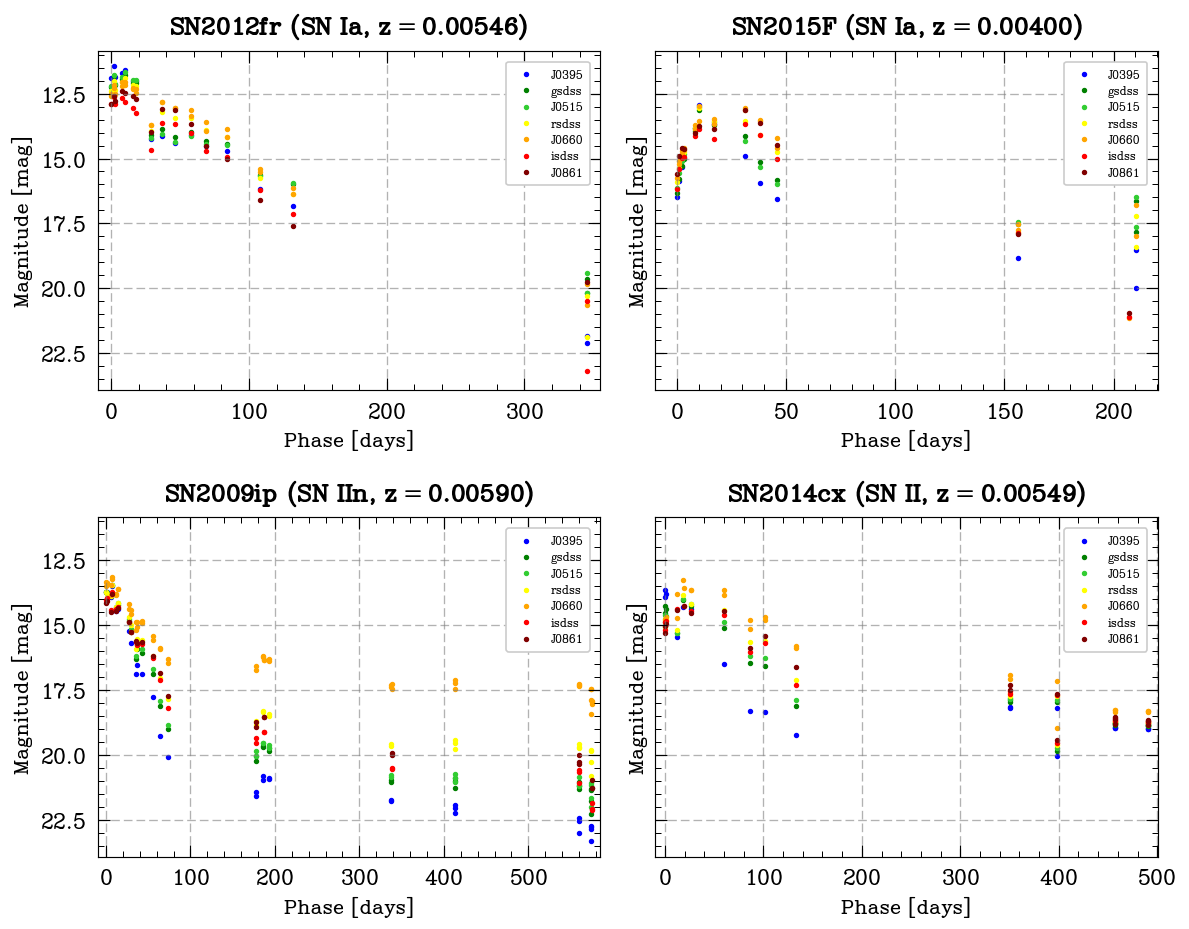

In [8]:
# Panel plot of different light curves
color_map = {'J0395': 'blue', 'gsdss': 'green', 'J0515': 'limegreen', 'rsdss': 'yellow',
        'J0660': 'orange', 'isdss': 'red', 'J0861': 'maroon'}
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# SN objects to plot
object_names = ['SN2012fr', 'SN2015F', 'SN2009ip', 'SN2014cx']

# Plot
plot_light_curves_panel(PESSTO_phot, bands, color_map, object_names)

## 3. SN comparison

In this section, we are going to do a diagram where the x-axis is the redshift and the y-axis is the number of spectra. In addition, we will put a colorbar showing the difference between the last and first spectra. The idea is to know which SNs have a low redshift and a high number of spectra. These SNs are going to be selected for our study. This plot is going to be done for the SNIA and SNII types.

Note: The low-redshift requirement avoids having H$\alpha$ emissions in other bands instead of in J0660. 

### 3.1. SN Ia

First, we work with SN Ia type.

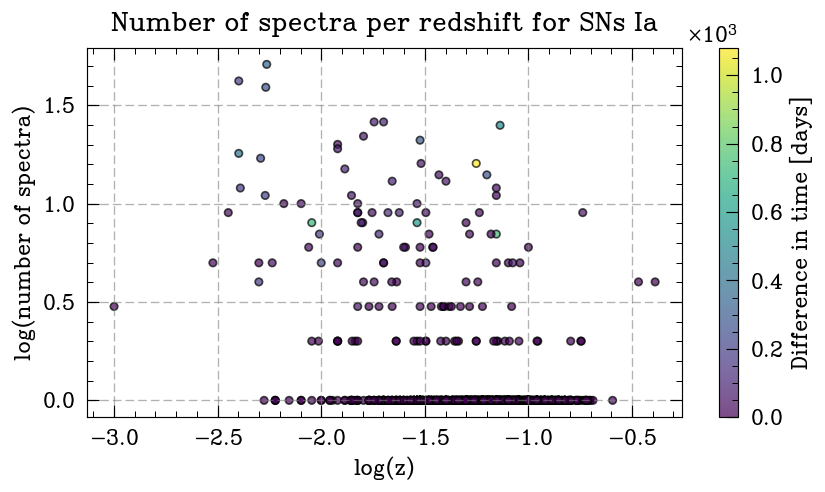

In [9]:
# Use only 'SNIa'
SNIa_tables = [table for table in PESSTO_phot if table['Type'][0] == 'SN Ia']

# Create list data
redshifts = []
num_spectra = []
time_diffs = []

for table in SNIa_tables:
    redshift = table['Redshift'][0]
    num_spec = len(table)
    time_diff = np.nanmax(table['Time']) - np.nanmin(table['Time'])
    
    redshifts.append(redshift)
    num_spectra.append(num_spec)
    time_diffs.append(time_diff)

# Convert do np.array
redshifts = np.array(redshifts)
num_spectra = np.array(num_spectra)
time_diffs = np.array(time_diffs)

# Plot
plt.figure(figsize=(8, 4))
sc = plt.scatter(np.log10(redshifts), np.log10(num_spectra), c=time_diffs, cmap='viridis', edgecolor='k', alpha=0.7, s=20)
plt.colorbar(sc, label='Difference in time [days]')
plt.xlabel('log(z)')
plt.ylabel('log(number of spectra)')
plt.title('Number of spectra per redshift for SNs Ia')
plt.grid(True)
#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/SNIa_redshift.pdf')
plt.show()

### 3.2. SN II

First, we work with SN II type.

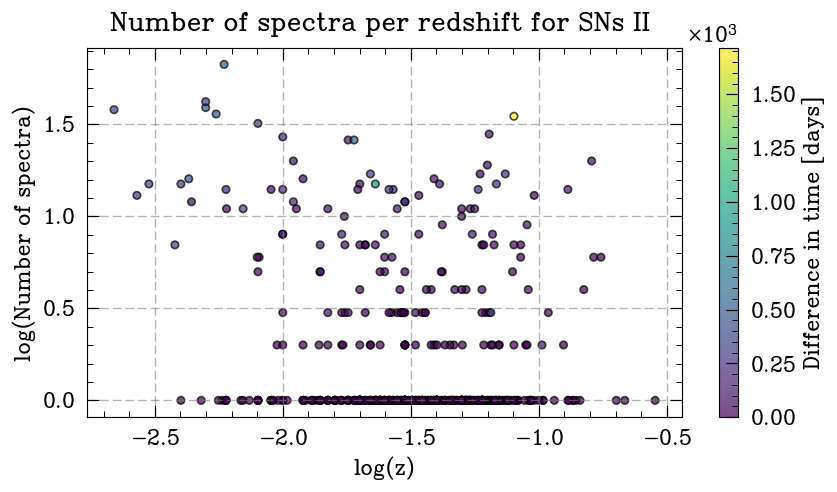

In [10]:
# Use only 'SNII' types
supernova_types = ['SN II', 'SN IIn', 'SN IIb', 'SN IIP']

# Filter data 
data = {'redshifts': [], 'num_spectra': [], 'time_diffs': []}

for table in PESSTO_phot:
    sntype = table['Type'][0]
    if sntype in supernova_types:
        redshift = table['Redshift'][0]
        num_spec = len(table)
        time_diff = np.nanmax(table['Time']) - np.nanmin(table['Time'])
        
        data['redshifts'].append(redshift)
        data['num_spectra'].append(num_spec)
        data['time_diffs'].append(time_diff)

# Convert to np.array
data['redshifts'] = np.array(data['redshifts'])
data['num_spectra'] = np.array(data['num_spectra'])
data['time_diffs'] = np.array(data['time_diffs'])

# Plot
plt.figure(figsize=(8, 4))

sc = plt.scatter(
    np.log10(data['redshifts']),
    np.log10(data['num_spectra']),
    c=data['time_diffs'],
    cmap='viridis',  
    edgecolor='k',
    alpha=0.7,
    s=20
)

plt.colorbar(sc, label='Difference in time [days]')

plt.xlabel('log(z)')
plt.ylabel('log(Number of spectra)')
plt.title('Number of spectra per redshift for SNs II ')
plt.grid(True)
#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/SNII_redshift.pdf')
plt.show()

## 4. Colour curves 

In this section, we are going to plot the colour (J0660-rsdss) curves for all the SNs. To do this, we are going to make a panel similar to the one done in section 2.2. The `plot_color_curves` and `plot_color_curves_panel` are going to be used. 

In [11]:
# Function I: plot color curves for some SNs
def plot_color_curves(data, bands, object_name, color_map, time_column='Time', mag_suffix='_mag', s=None, ax=None):
    if s is None:
        s = 20
    
    time = data[time_column]
    JD = time - np.min(time) 
    
    if ax is None:
        fig, ax = plt.subplots()
    
    xlim_min, xlim_max = np.inf, -np.inf
    color_values = []
    color_map_values = []
    
    for band1, band2 in bands:
        if f"{band1}{mag_suffix}" in data.colnames and f"{band2}{mag_suffix}" in data.colnames:
            mag1 = data[f"{band1}{mag_suffix}"]
            mag2 = data[f"{band2}{mag_suffix}"]
            color = color_map.get((band1, band2), 'black') 
            
            # Calculate the color
            color_curve = mag1 - mag2
            color_values.extend(color_curve)  # Collect color values for colorbar
            
            # Optional: calculate error for color curve if errors are available
            mag_error1_col = f"e_{band1}{mag_suffix}"
            mag_error2_col = f"e_{band2}{mag_suffix}"
            mag_error1 = data[mag_error1_col] if mag_error1_col in data.colnames else None
            mag_error2 = data[mag_error2_col] if mag_error2_col in data.colnames else None
            
            if mag_error1 is not None and mag_error2 is not None:
                color_error = np.sqrt(mag_error1**2 + mag_error2**2)
                sc = ax.errorbar(JD, color_curve, yerr=color_error, label=f"{band1} - {band2}", color=color, fmt='o', capsize=3, markersize=s)
            else:
                norm = plt.Normalize(min(color_values), max(color_values))
                sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
                
                # Assign colors based on color_curve
                colors = sm.to_rgba(color_curve)
                
                # Plot with color map
                sc = ax.scatter(JD, color_curve, c=colors, s=s, label=f"{band1} - {band2}")
                
                # Use sm to create a colorbar
                if 'cbar' not in locals():
                    sm.set_array([])
                    cbar = plt.colorbar(sm, ax=ax, label='Color [mag]')
                    cbar.ax.tick_params(labelsize=8)
                
            # Update x limits based on current data
            xlim_min = min(xlim_min, JD.min())
            xlim_max = max(xlim_max, JD.max())
    
    # Set x and y axis labels
    ax.set_xlabel('Phase [days]', fontsize=14)
    ax.set_ylabel('Color (rsdss - J0660) [mag]', fontsize=14)
    ax.legend(fontsize=10, frameon=True)
    ax.grid(True)
    
    # Return x limits
    return xlim_min, xlim_max

# Function II: plot color curves as a panel for some SNs
def plot_color_curves_panel(tables, bands, color_map, object_names, time_column='Time', mag_suffix='_mag', s=None):
    n = len(object_names)
    n_cols = 2
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows), sharex=False, sharey=True)
    axes = axes.flatten()

    for i, object_name in enumerate(object_names):
        ax = axes[i]
        table = find_object(object_name)

        if table is not None:
            object_type = table['Type'][0]  
            redshift = table['Redshift'][0]
            xlim_min, xlim_max = plot_color_curves(table, bands, object_name, color_map, time_column, mag_suffix, s, ax)
            ax.set_xlim(xlim_min-10, xlim_max+10)
            ax.set_title(rf"{object_name} ({object_type}, z$=${redshift:.5f})", fontweight='bold')
        else:
            ax.text(0.5, 0.5, f'No data for {object_name}', ha='center', va='center', fontsize=12)
            ax.set_title(object_name, fontweight='bold')

    # Remove empty subplots
    for j in range(len(object_names), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    #plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/SNs_color_curve_panel.pdf')
    plt.show()

Now, we plot the panel with different light curves.

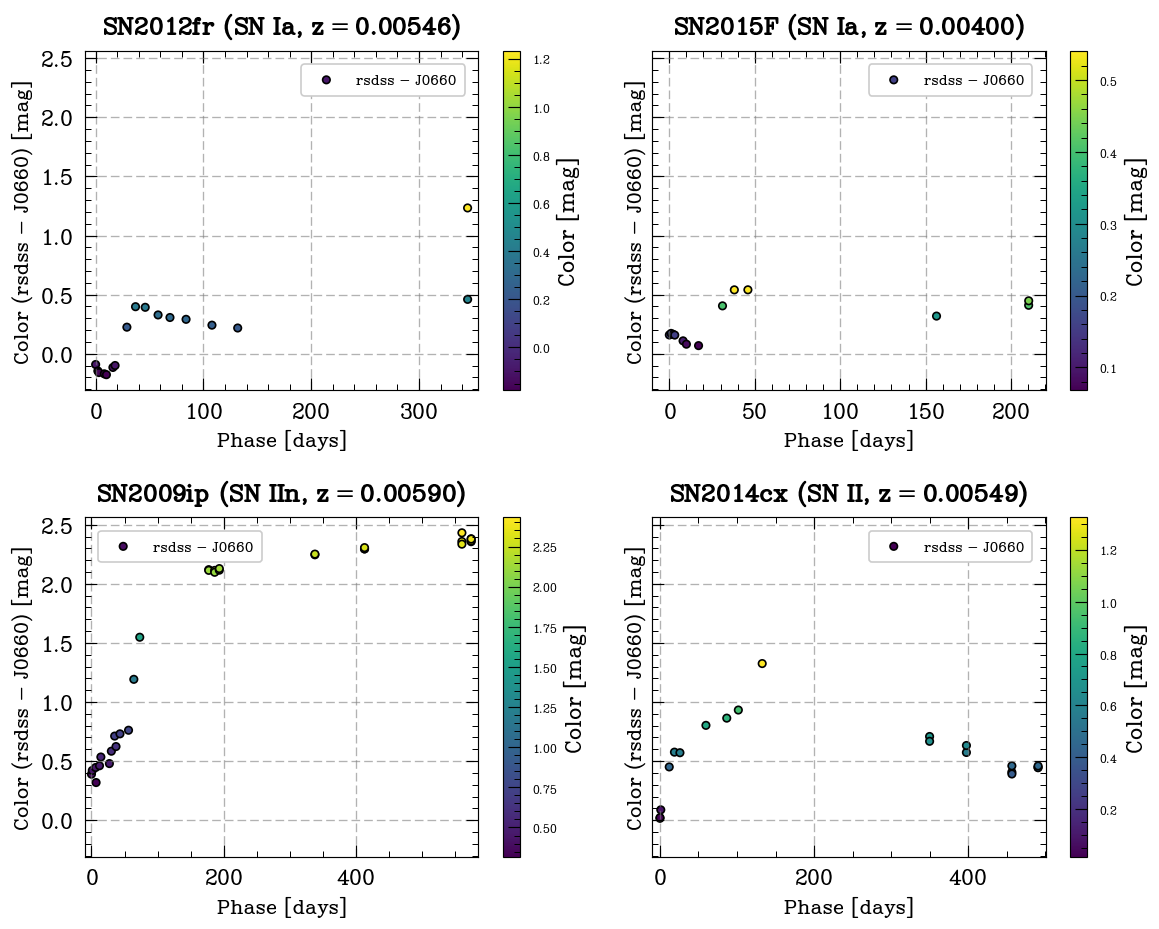

In [12]:
# Bands and color maps
bands = [('rsdss', 'J0660')]
color_map = {('rsdss', 'J0660'): 'blue'}

# Objects to study
object_names = ['SN2012fr', 'SN2015F', 'SN2009ip', 'SN2014cx']

# Plot
plot_color_curves_panel(PESSTO_phot, bands, color_map, object_names)

## 5. SN classification

In this section, we are going to do one of the most important results of this project: classify the SNs using J-VAR filters. To do this, we are going to select all the light curves of SN Ia and SN II and re-scale them on flux and time. The main idea is to obtain a universal light curve for both types. In this way, when J-VAR detect an SN, its light curve can be plotted over the different universal light curves to see what SN type it is.

### 5.1. SN Ia

We start by obtaining the universal light curve for SNs Ia.

In [13]:
# SN Ia (list of SNs Ia tables)
SNIa_phot = [table for table in PESSTO_phot if 'SN Ia' in table['Type']]

data_points = 5
SNIa_phot = [table for table in SNIa_phot if len(table) > data_points] # We take the SNs Ia with more than 8 data points
print(f'We have selected {len(SNIa_phot)} SNs Ia with more than {data_points} points.')

We have selected 56 SNs Ia with more than 5 points.


Plot normalized light curves using `normalize_data` and `plot_light_curves_normalized` created functions.

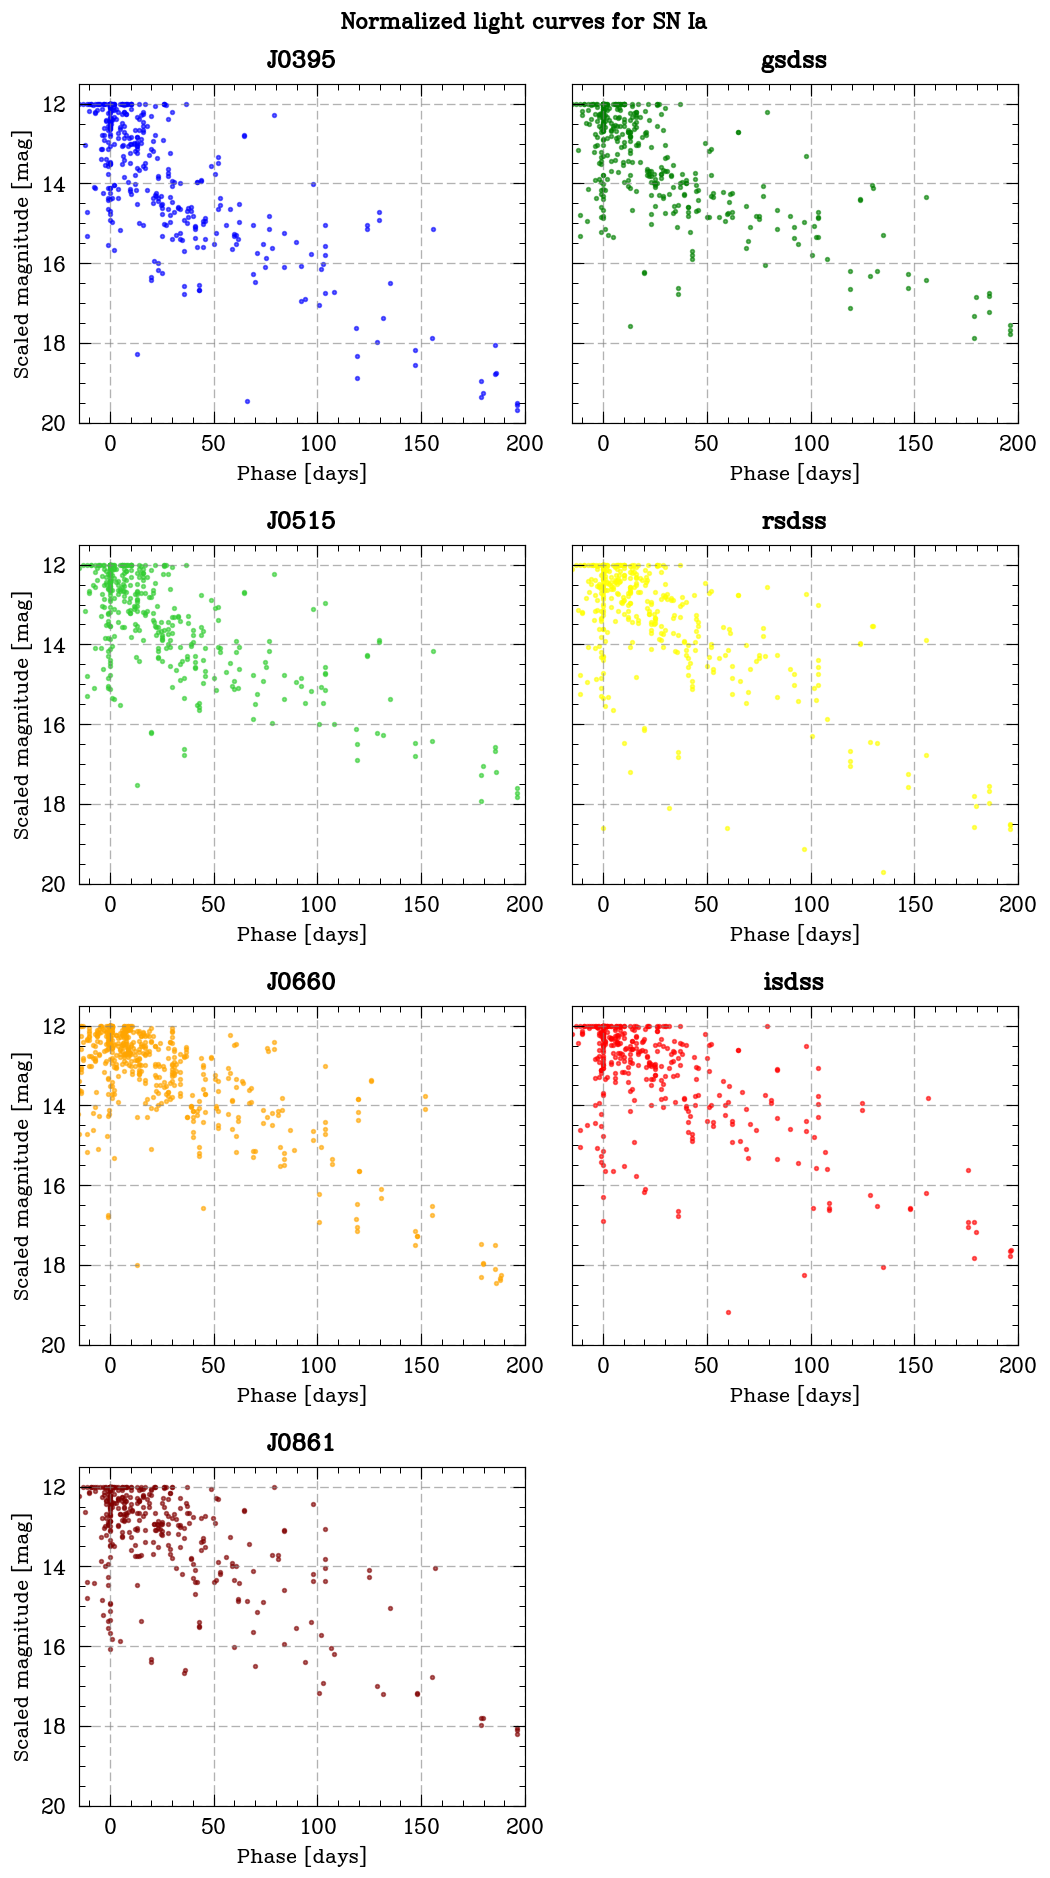

In [14]:
# Function to plot all SN light curves in separate panels for each filter, organized in 2 columns
def plot_all_sns_by_filter(tables, bands, color_map, time_column='Time', mag_suffix='_mag', error_prefix='e_', s=None):
    
    if s is None:
        s = 5
    
    n_bands = len(bands)
    n_cols = 2
    n_rows = (n_bands + n_cols - 1) // n_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4 * n_rows), sharey=True)
    axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over

    for i, band in enumerate(bands):
        ax = axes[i]
        xlim_min, xlim_max = np.inf, -np.inf
        
        for table in tables:# for each SN
            time = table[time_column]
            
            if f"{band}{mag_suffix}" in table.colnames:
                mag = table[f"{band}{mag_suffix}"]
                color = color_map.get(band, 'black')

                # Find peak of the light curve
                max_indice = np.argmin(mag)
                time_max = time[max_indice]
                mag_max = mag[max_indice]

                # set t=0 for the peak
                JD = time - time_max
                
                mag_error_col = f"{error_prefix}{band}{mag_suffix}"
                mag_error = table[mag_error_col] if mag_error_col in table.colnames else None
                mag_norm = mag - np.nanmin(mag) + 12
                
                if mag_error is not None:
                    ax.errorbar(JD, mag_norm, yerr=mag_error, label=band, color=color, fmt='o', capsize=3, markersize=s, alpha=0.6)
                else:
                    ax.scatter(JD, mag_norm, label=band, color=color, s=s, alpha=0.6)
        
        ax.set_xlabel('Phase [days]', fontsize=14)
        ax.set_title(f"{band}", fontweight='bold')
        ax.set_xlim(-15,200) # time limits
        ax.set_ylim(11.5,20)
        ax.invert_yaxis()
        ax.grid(True)
        
        if i % n_cols == 0:
            ax.set_ylabel('Scaled magnitude [mag]', fontsize=14)
    
    # Remove empty subplot if number of bands is odd
    if n_bands % n_cols != 0:
        fig.delaxes(axes[-1])

    fig.suptitle('Normalized light curves for SN Ia', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Color map and bands definition
color_map = {'J0395': 'blue', 'gsdss': 'green', 'J0515': 'limegreen', 'rsdss': 'yellow',
        'J0660': 'orange', 'isdss': 'red', 'J0861': 'maroon'}
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Plot light curves panel by filter for all SNe
plot_all_sns_by_filter(SNIa_phot, bands, color_map)

### 5.2. SN II

We start by obtaining the universal light curve for SNs Ia.

In [15]:
# SN II (list of SNs Ia tables)
SNII_phot = [table for table in PESSTO_phot if 'SN II' or 'SN IIn' or 'SN IIb' or 'SN IIP' in table['Type']]

data_points = 5
SNII_phot = [table for table in SNII_phot if len(table) > data_points] # We take the SNs Ia with more than 8 data points
print(f'We have selected {len(SNII_phot)} SNs II with more than {data_points} points.')

We have selected 207 SNs II with more than 5 points.


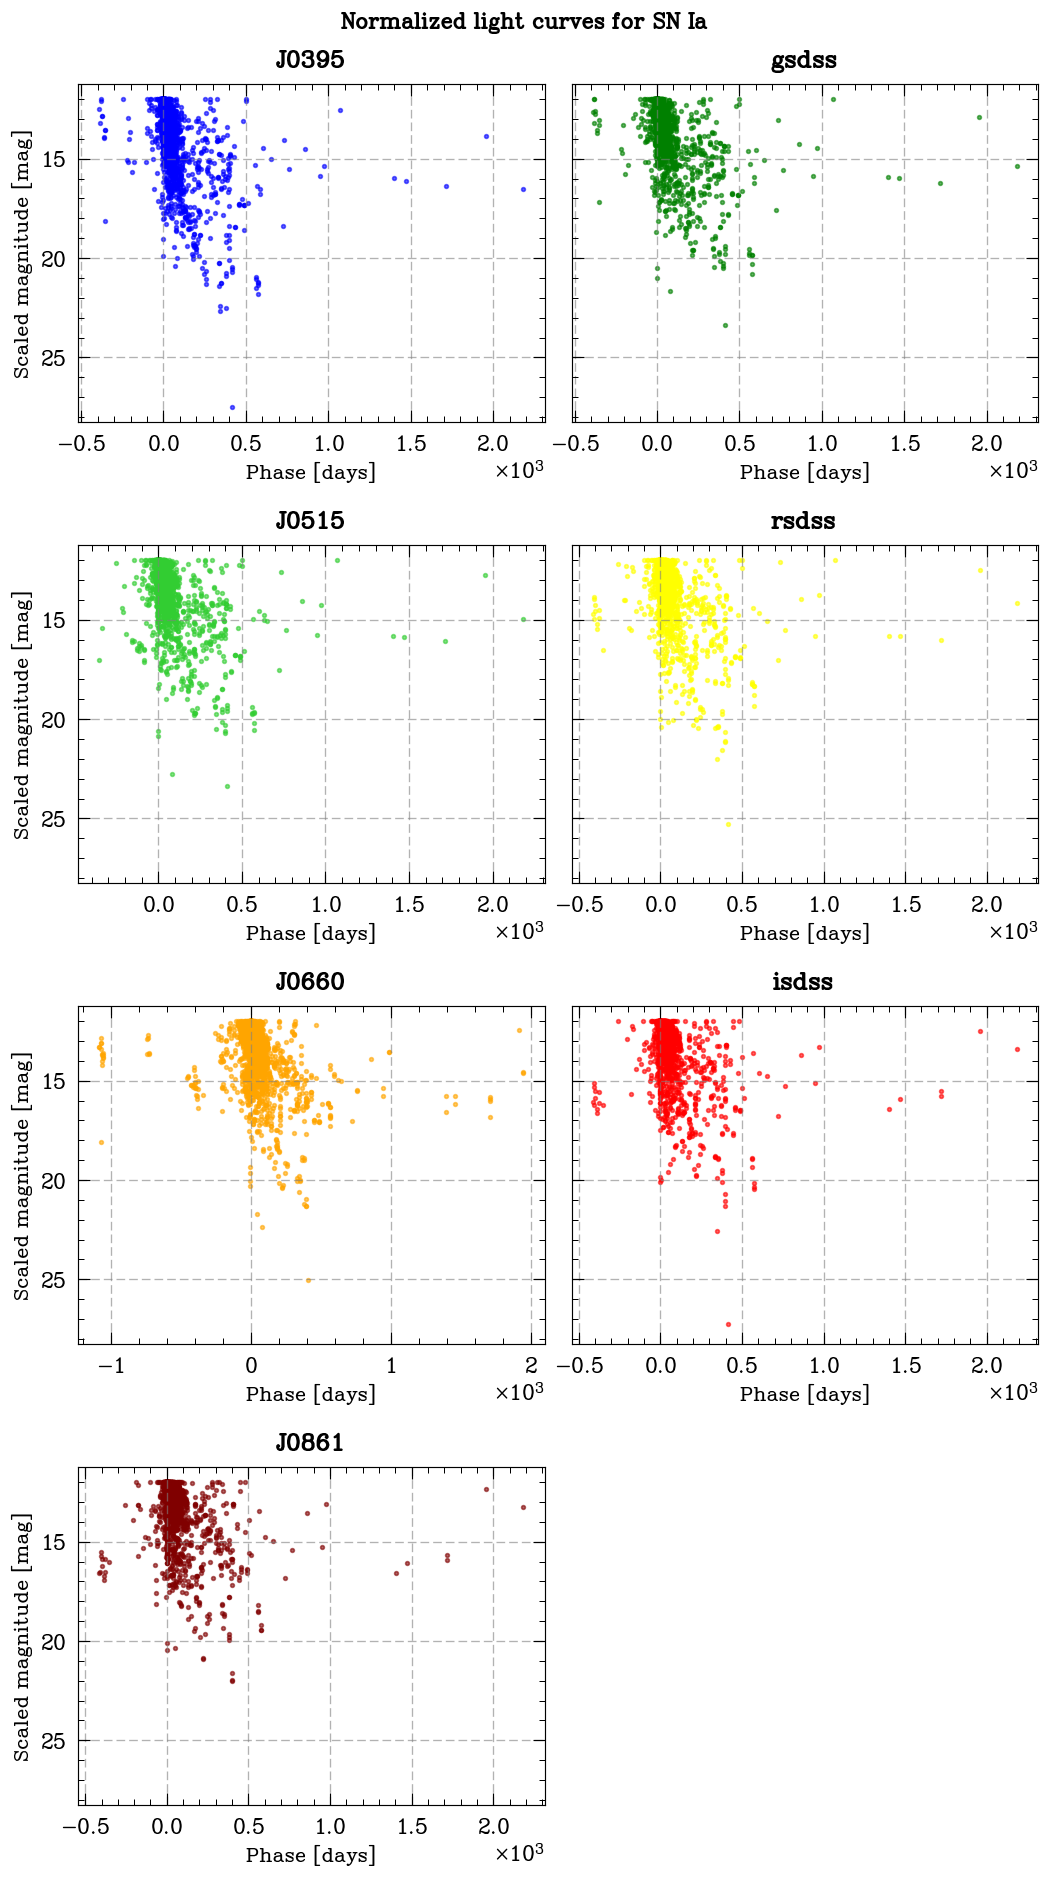

In [16]:
# Function to plot all SN light curves in separate panels for each filter, organized in 2 columns
def plot_all_sns_by_filter(tables, bands, color_map, time_column='Time', mag_suffix='_mag', error_prefix='e_', s=None):
    
    if s is None:
        s = 5
    
    n_bands = len(bands)
    n_cols = 2
    n_rows = (n_bands + n_cols - 1) // n_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4 * n_rows), sharey=True)
    axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over

    for i, band in enumerate(bands):
        ax = axes[i]
        xlim_min, xlim_max = np.inf, -np.inf
        
        for table in tables:# for each SN
            time = table[time_column]
            
            if f"{band}{mag_suffix}" in table.colnames:
                mag = table[f"{band}{mag_suffix}"]
                color = color_map.get(band, 'black')

                # Find peak of the light curve
                max_indice = np.argmin(mag)
                time_max = time[max_indice]
                mag_max = mag[max_indice]

                # set t=0 for the peak
                JD = time - time_max
                
                mag_error_col = f"{error_prefix}{band}{mag_suffix}"
                mag_error = table[mag_error_col] if mag_error_col in table.colnames else None
                mag_norm = mag - np.nanmin(mag) + 12
                
                if mag_error is not None:
                    ax.errorbar(JD, mag_norm, yerr=mag_error, label=band, color=color, fmt='o', capsize=3, markersize=s, alpha=0.6)
                else:
                    ax.scatter(JD, mag_norm, label=band, color=color, s=s, alpha=0.6)
        
        ax.set_xlabel('Phase [days]', fontsize=14)
        ax.set_title(f"{band}", fontweight='bold')
        #ax.set_xlim(-15,500) # time limits
        ax.invert_yaxis()
        ax.grid(True)
        
        if i % n_cols == 0:
            ax.set_ylabel('Scaled magnitude [mag]', fontsize=14)
    
    # Remove empty subplot if number of bands is odd
    if n_bands % n_cols != 0:
        fig.delaxes(axes[-1])

    fig.suptitle('Normalized light curves for SN Ia', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Color map and bands definition
color_map = {'J0395': 'blue', 'gsdss': 'green', 'J0515': 'limegreen', 'rsdss': 'yellow',
        'J0660': 'orange', 'isdss': 'red', 'J0861': 'maroon'}
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Plot light curves panel by filter for all SNe
plot_all_sns_by_filter(SNII_phot, bands, color_map)

## 6. Light curves with s-factor

In this section, we are going to try to repeat Section 5 but with another method. This is based on fitting all the light curves for SNs Ia and SNs II. Then, by taking one as a reference, we are going to calculate the s-factor (stretch factor) by minimising the difference between the fitted light curve from a reference light curve and the science light curve.

### 6.1. SN Ia

We start with SN Ia.

In [17]:
# To do ...

### 6.2. SN II

We continue with SN II.

In [18]:
# To do ...

## Appendix A: Light curves with s-factor fix (fail)

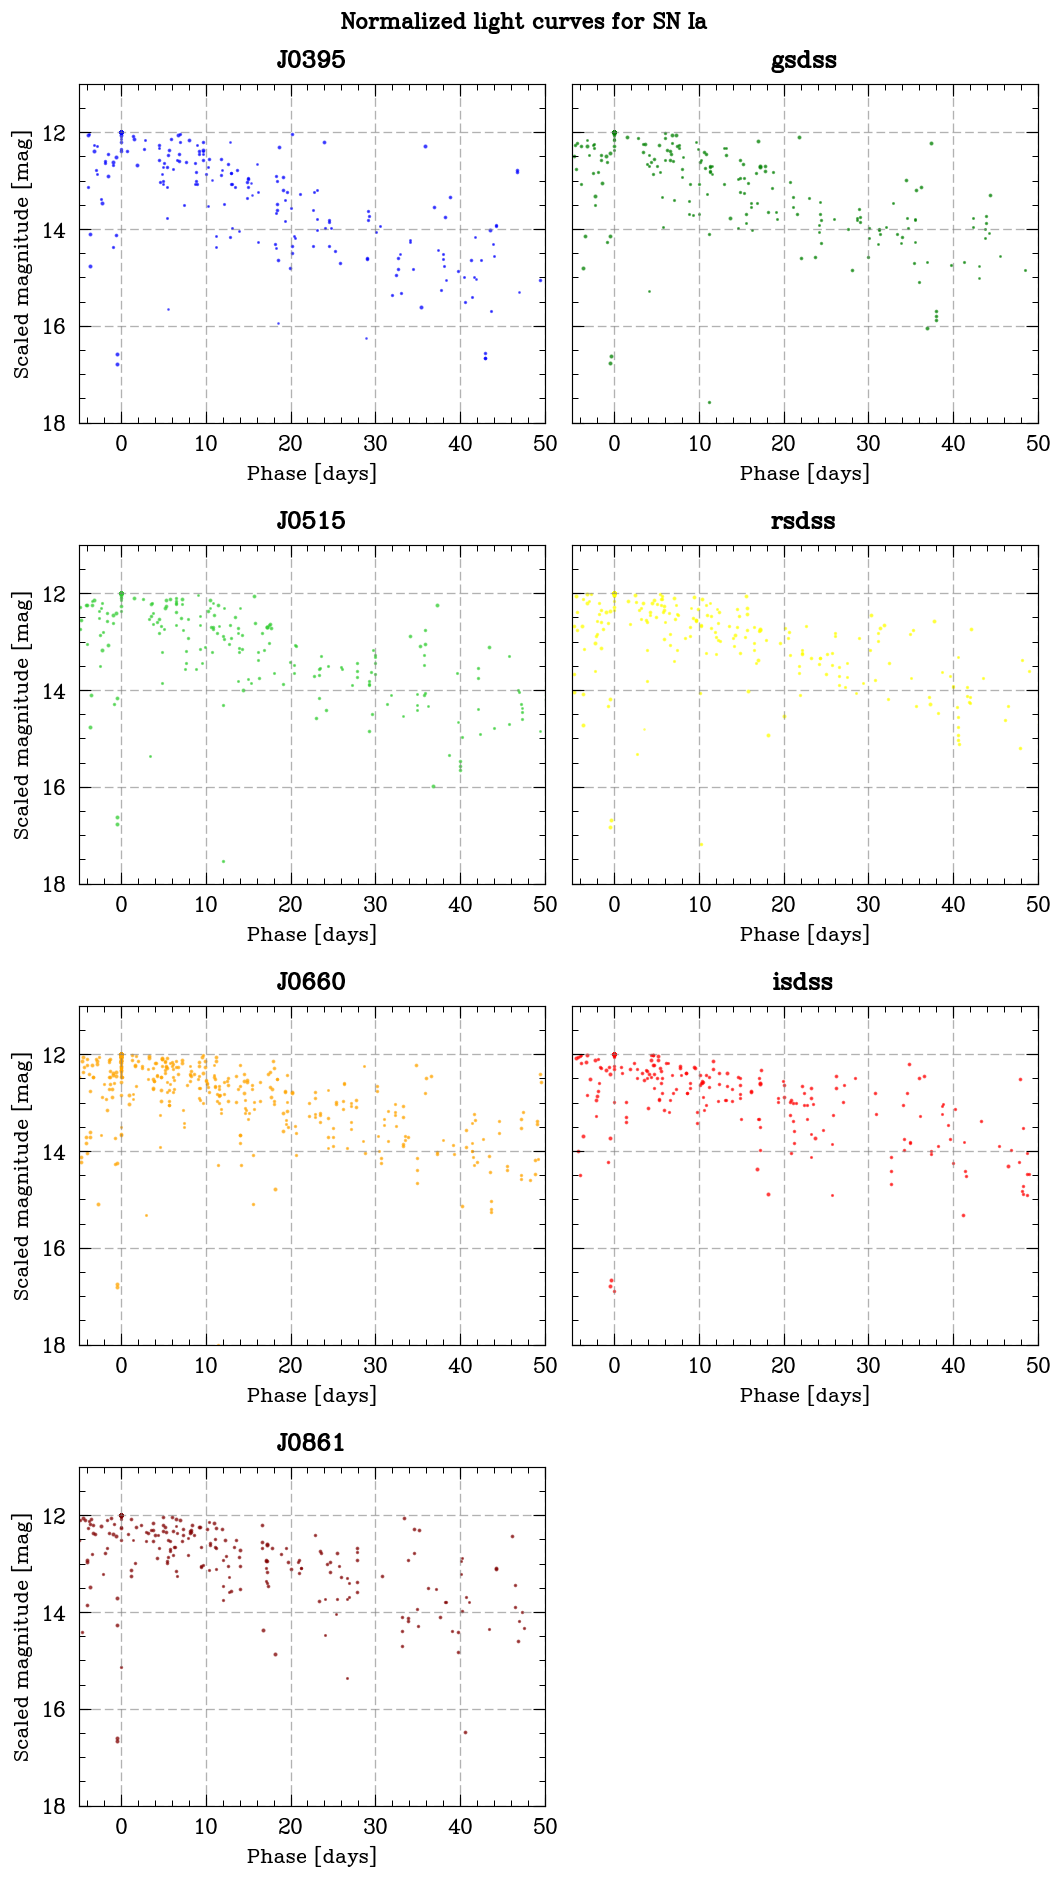

In [19]:
# Function to plot all SN light curves in separate panels for each filter, organized in 2 columns
def plot_all_sns_by_filter(tables, bands, color_map, time_column='Time', mag_suffix='_mag', error_prefix='e_', s=None):
    
    if s is None:
        s = 10
    
    n_bands = len(bands)
    n_cols = 2
    n_rows = (n_bands + n_cols - 1) // n_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4 * n_rows), sharey=True)
    axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over
    
    deltam15_dict = {}  # Dictionary to store Delta_m_15 for each SN and band

    for i, band in enumerate(bands):
        ax = axes[i]
        xlim_min, xlim_max = np.inf, -np.inf
        
        for sn_idx, table in enumerate(tables):  # for each SN
            time = table[time_column]
            
            if f"{band}{mag_suffix}" in table.colnames:
                mag = table[f"{band}{mag_suffix}"]
                color = color_map.get(band, 'black')

                # Find peak of the light curve (non-NaN maximum)
                valid_indices = ~np.isnan(mag)
                if np.any(valid_indices):
                    valid_time = time[valid_indices]
                    valid_mag = mag[valid_indices]
                    
                    max_indice = np.argmin(valid_mag)
                    time_max = valid_time[max_indice]
                    mag_max = valid_mag[max_indice]
                    
                    # set t=0 for the peak
                    JD = time - time_max
                    
                    mag_error_col = f"{error_prefix}{band}{mag_suffix}"
                    mag_error = table[mag_error_col] if mag_error_col in table.colnames else None
                    mag_norm = mag - np.nanmin(mag) + 12
                    
                    # Calculate Delta_m_15
                    time_plus_15_days = 15
                    valid_JD = JD[valid_indices]
                    if np.any(~np.isnan(mag)):
                        closest_index = np.argmin(np.abs(valid_JD - time_plus_15_days))
                        closest_index = np.where(valid_indices)[0][closest_index]
                        mag_15_days = mag[closest_index]
                        deltam15 = mag_15_days - mag_max
                    else:
                        deltam15 = np.nan
                    
                    if sn_idx not in deltam15_dict:
                        deltam15_dict[sn_idx] = {}
                    deltam15_dict[sn_idx][band] = deltam15

                    s = 1.96 / (deltam15 + 0.89)

                    if mag_error is not None:
                        ax.errorbar(JD/s, mag_norm, yerr=mag_error, label=band, color=color, fmt='o', capsize=3, markersize=s, alpha=0.6)
                    else:
                        ax.scatter(JD/s, mag_norm, label=band, color=color, s=s, alpha=0.6)
        
        ax.set_xlabel('Phase [days]', fontsize=14)
        ax.set_title(f"{band}", fontweight='bold')
        ax.set_xlim(-5,50) # time limits
        ax.set_ylim(11,18)
        ax.invert_yaxis()
        ax.grid(True)
        
        if i % n_cols == 0:
            ax.set_ylabel('Scaled magnitude [mag]', fontsize=14)
    
    # Remove empty subplot if number of bands is odd
    if n_bands % n_cols != 0:
        fig.delaxes(axes[-1])

    fig.suptitle('Normalized light curves for SN Ia', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    return deltam15_dict

# Color map and bands definition
color_map = {'J0395': 'blue', 'gsdss': 'green', 'J0515': 'limegreen', 'rsdss': 'yellow',
        'J0660': 'orange', 'isdss': 'red', 'J0861': 'maroon'}
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Plot light curves panel by filter for all SNe and calculate Delta_m_15
deltam15_results = plot_all_sns_by_filter(SNIa_phot, bands, color_map)

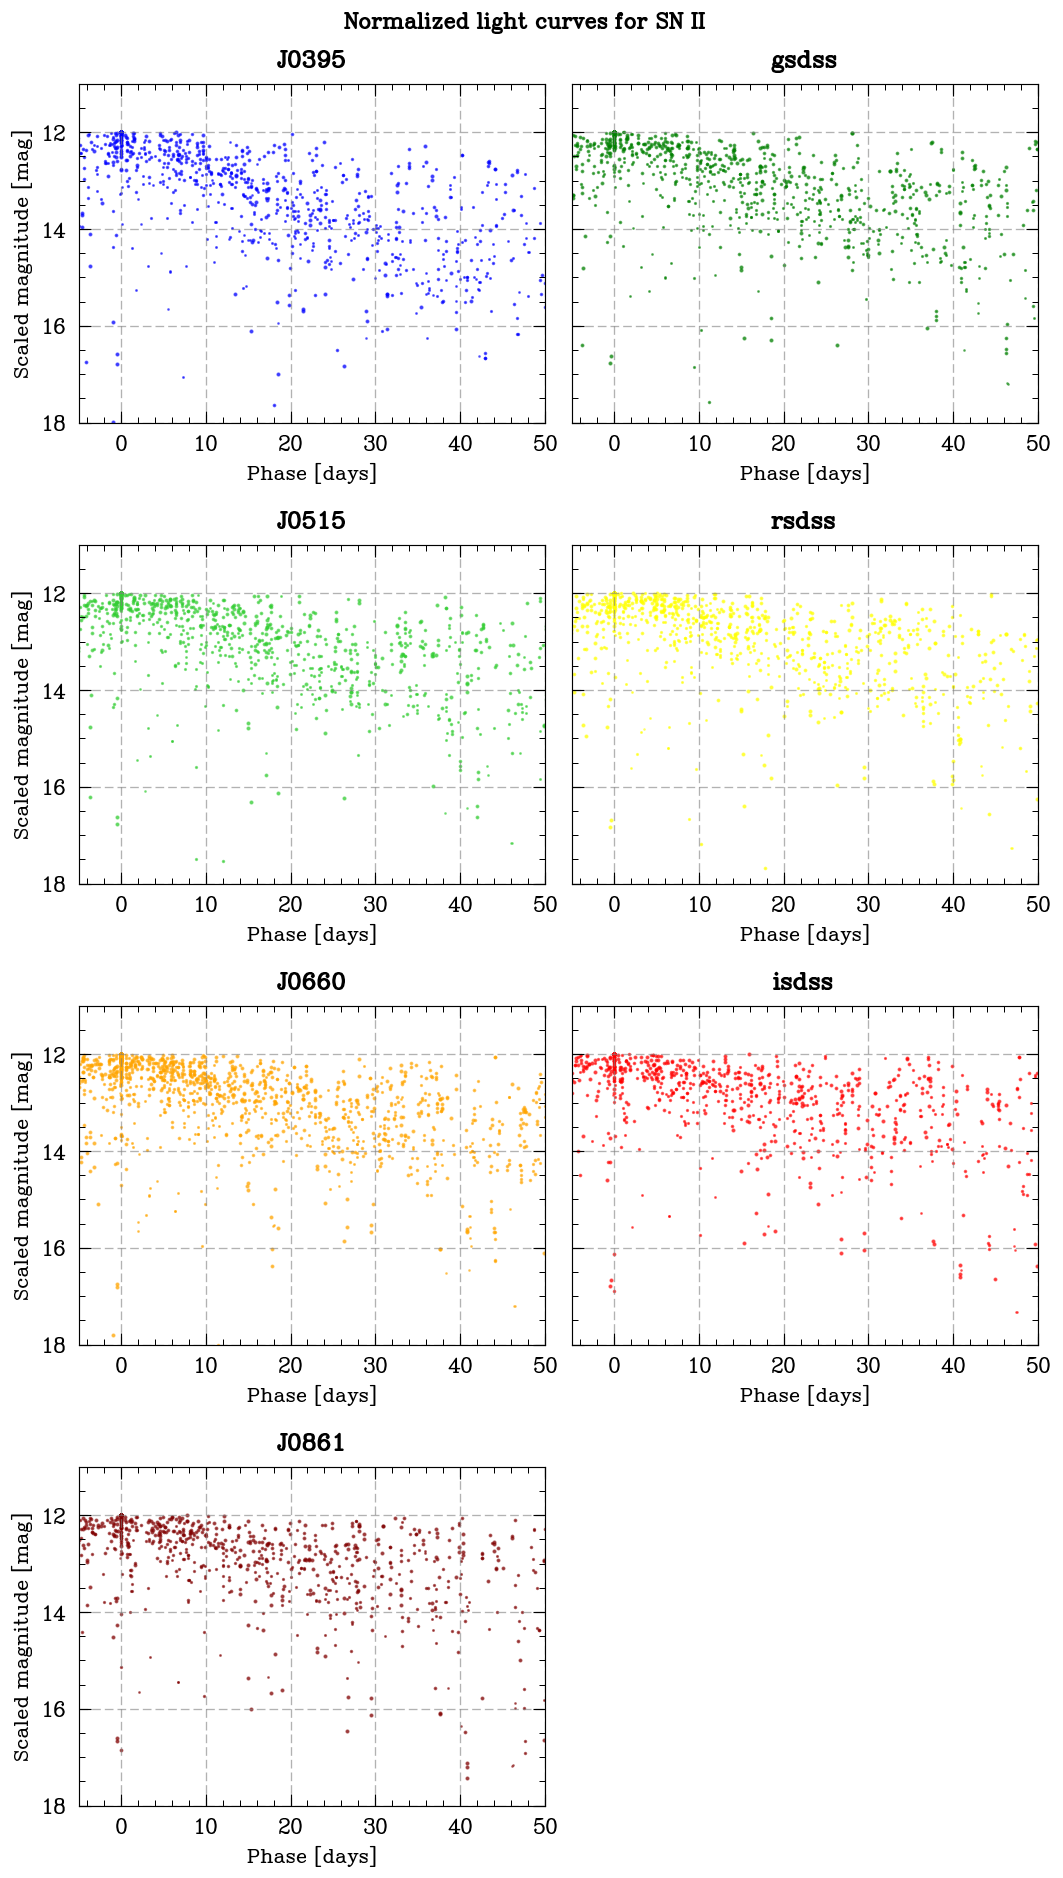

In [20]:
# Function to plot all SN light curves in separate panels for each filter, organized in 2 columns
def plot_all_sns_by_filter(tables, bands, color_map, time_column='Time', mag_suffix='_mag', error_prefix='e_', s=None):
    
    if s is None:
        s = 10
    
    n_bands = len(bands)
    n_cols = 2
    n_rows = (n_bands + n_cols - 1) // n_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4 * n_rows), sharey=True)
    axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over
    
    deltam15_dict = {}  # Dictionary to store Delta_m_15 for each SN and band

    for i, band in enumerate(bands):
        ax = axes[i]
        xlim_min, xlim_max = np.inf, -np.inf
        
        for sn_idx, table in enumerate(tables):  # for each SN
            time = table[time_column]
            
            if f"{band}{mag_suffix}" in table.colnames:
                mag = table[f"{band}{mag_suffix}"]
                color = color_map.get(band, 'black')

                # Find peak of the light curve (non-NaN maximum)
                valid_indices = ~np.isnan(mag)
                if np.any(valid_indices):
                    valid_time = time[valid_indices]
                    valid_mag = mag[valid_indices]
                    
                    max_indice = np.argmin(valid_mag)
                    time_max = valid_time[max_indice]
                    mag_max = valid_mag[max_indice]
                    
                    # set t=0 for the peak
                    JD = time - time_max
                    
                    mag_error_col = f"{error_prefix}{band}{mag_suffix}"
                    mag_error = table[mag_error_col] if mag_error_col in table.colnames else None
                    mag_norm = mag - np.nanmin(mag) + 12
                    
                    # Calculate Delta_m_15
                    time_plus_15_days = 15
                    valid_JD = JD[valid_indices]
                    if np.any(~np.isnan(mag)):
                        closest_index = np.argmin(np.abs(valid_JD - time_plus_15_days))
                        closest_index = np.where(valid_indices)[0][closest_index]
                        mag_15_days = mag[closest_index]
                        deltam15 = mag_15_days - mag_max
                    else:
                        deltam15 = np.nan
                    
                    if sn_idx not in deltam15_dict:
                        deltam15_dict[sn_idx] = {}
                    deltam15_dict[sn_idx][band] = deltam15

                    s = 1.96 / (deltam15 + 0.89)

                    if mag_error is not None:
                        ax.errorbar(JD/s, mag_norm, yerr=mag_error, label=band, color=color, fmt='o', capsize=3, markersize=s, alpha=0.6)
                    else:
                        ax.scatter(JD/s, mag_norm, label=band, color=color, s=s, alpha=0.6)
        
        ax.set_xlabel('Phase [days]', fontsize=14)
        ax.set_title(f"{band}", fontweight='bold')
        ax.set_xlim(-5,50) # time limits
        ax.set_ylim(11,18)
        ax.invert_yaxis()
        ax.grid(True)
        
        if i % n_cols == 0:
            ax.set_ylabel('Scaled magnitude [mag]', fontsize=14)
    
    # Remove empty subplot if number of bands is odd
    if n_bands % n_cols != 0:
        fig.delaxes(axes[-1])

    fig.suptitle('Normalized light curves for SN II', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    return deltam15_dict

# Color map and bands definition
color_map = {'J0395': 'blue', 'gsdss': 'green', 'J0515': 'limegreen', 'rsdss': 'yellow',
        'J0660': 'orange', 'isdss': 'red', 'J0861': 'maroon'}
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Plot light curves panel by filter for all SNe and calculate Delta_m_15
deltam15_results = plot_all_sns_by_filter(SNII_phot, bands, color_map)

## Appendix B: Light curve in logarithm scale

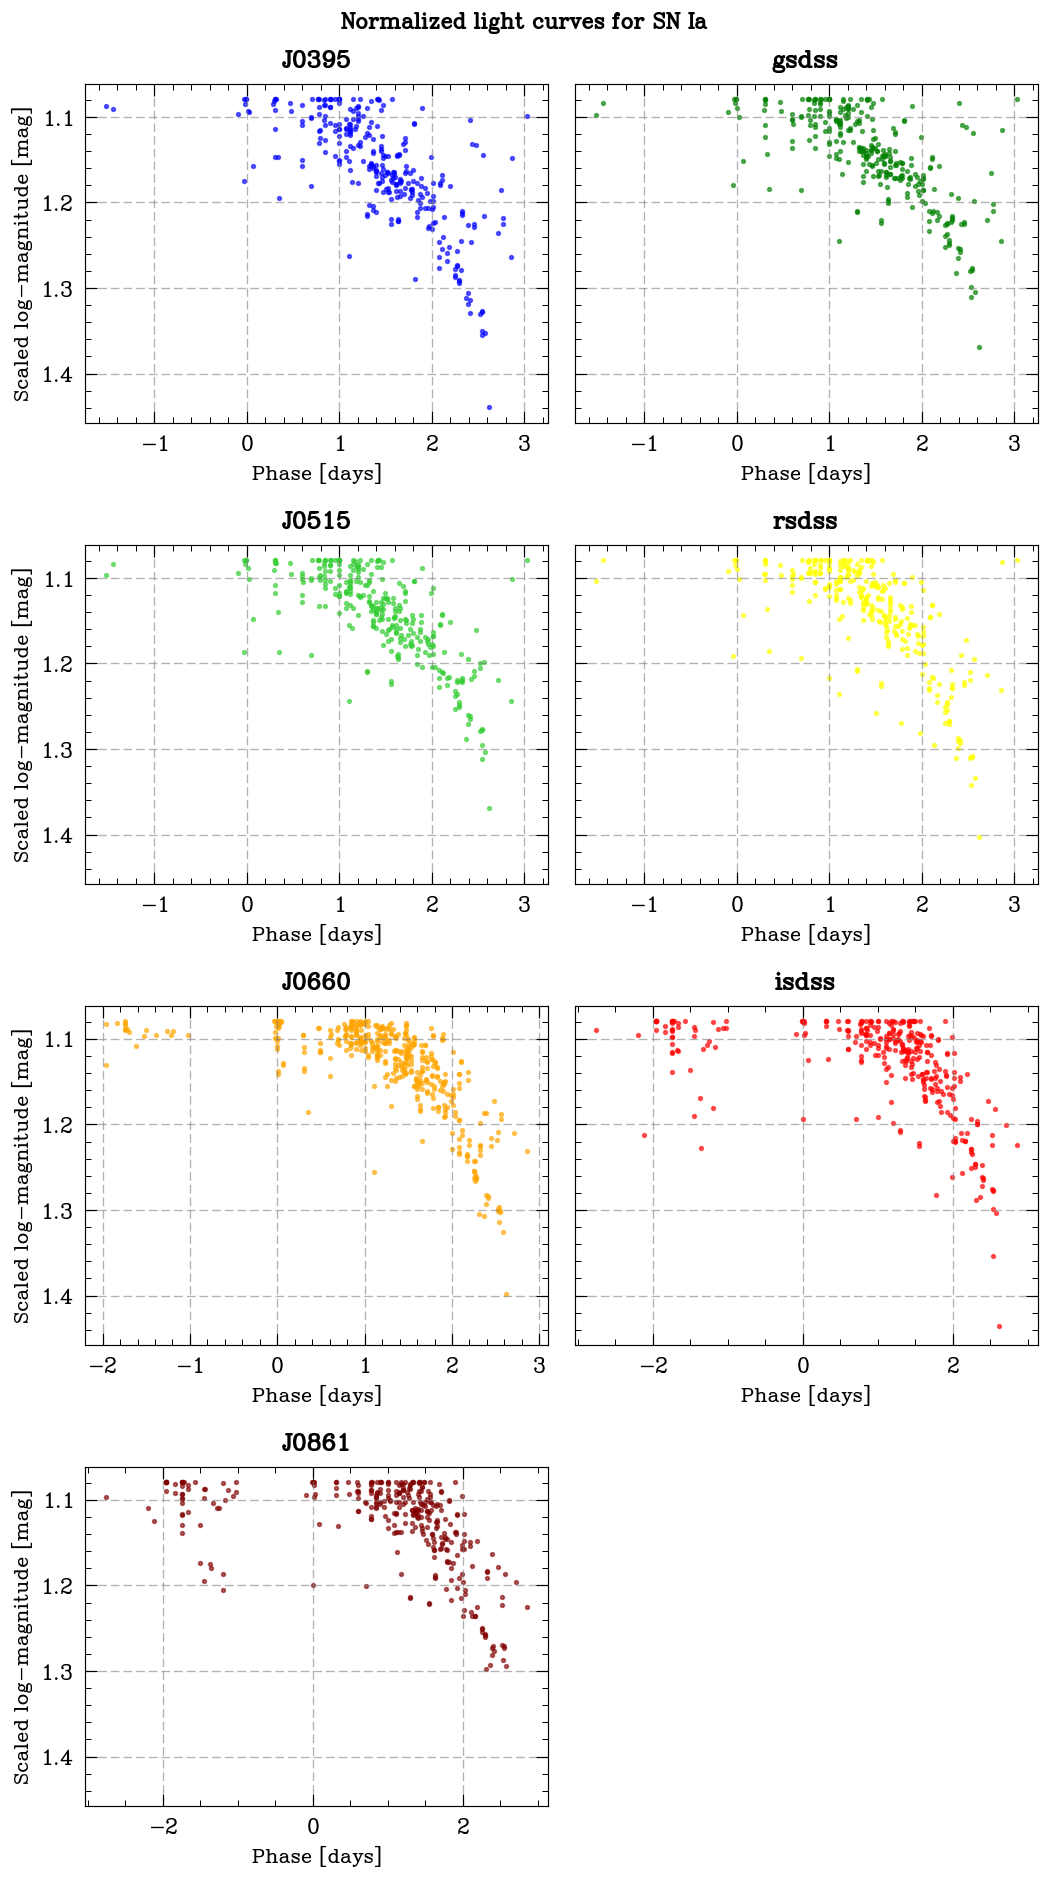

In [21]:
# Function to plot all SN light curves in separate panels for each filter, organized in 2 columns
def plot_all_sns_by_filter(tables, bands, color_map, time_column='Time', mag_suffix='_mag', error_prefix='e_', s=None):
    
    if s is None:
        s = 5
    
    n_bands = len(bands)
    n_cols = 2
    n_rows = (n_bands + n_cols - 1) // n_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4 * n_rows), sharey=True)
    axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over

    for i, band in enumerate(bands):
        ax = axes[i]
        xlim_min, xlim_max = np.inf, -np.inf
        
        for table in tables:# for each SN
            time = table[time_column]
            
            if f"{band}{mag_suffix}" in table.colnames:
                mag = table[f"{band}{mag_suffix}"]
                color = color_map.get(band, 'black')

                # Find peak of the light curve
                max_indice = np.argmin(mag)
                time_max = time[max_indice]
                mag_max = mag[max_indice]

                # set t=0 for the peak
                JD = time - time_max
                
                mag_error_col = f"{error_prefix}{band}{mag_suffix}"
                mag_error = table[mag_error_col] if mag_error_col in table.colnames else None
                mag_norm = mag - np.nanmin(mag) + 12
                
                if mag_error is not None:
                    ax.errorbar(np.log10(JD), np.log10(mag_norm), yerr=mag_error, label=band, color=color, fmt='o', capsize=3, markersize=s, alpha=0.6)
                else:
                    ax.scatter(np.log10(JD), np.log10(mag_norm), label=band, color=color, s=s, alpha=0.6)
        
        ax.set_xlabel('Phase [days]', fontsize=14)
        ax.set_title(f"{band}", fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True)
        
        if i % n_cols == 0:
            ax.set_ylabel('Scaled log-magnitude [mag]', fontsize=14)
    
    # Remove empty subplot if number of bands is odd
    if n_bands % n_cols != 0:
        fig.delaxes(axes[-1])

    fig.suptitle('Normalized light curves for SN Ia', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Color map and bands definition
color_map = {'J0395': 'blue', 'gsdss': 'green', 'J0515': 'limegreen', 'rsdss': 'yellow',
        'J0660': 'orange', 'isdss': 'red', 'J0861': 'maroon'}
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Plot light curves panel by filter for all SNe
plot_all_sns_by_filter(SNIa_phot, bands, color_map)

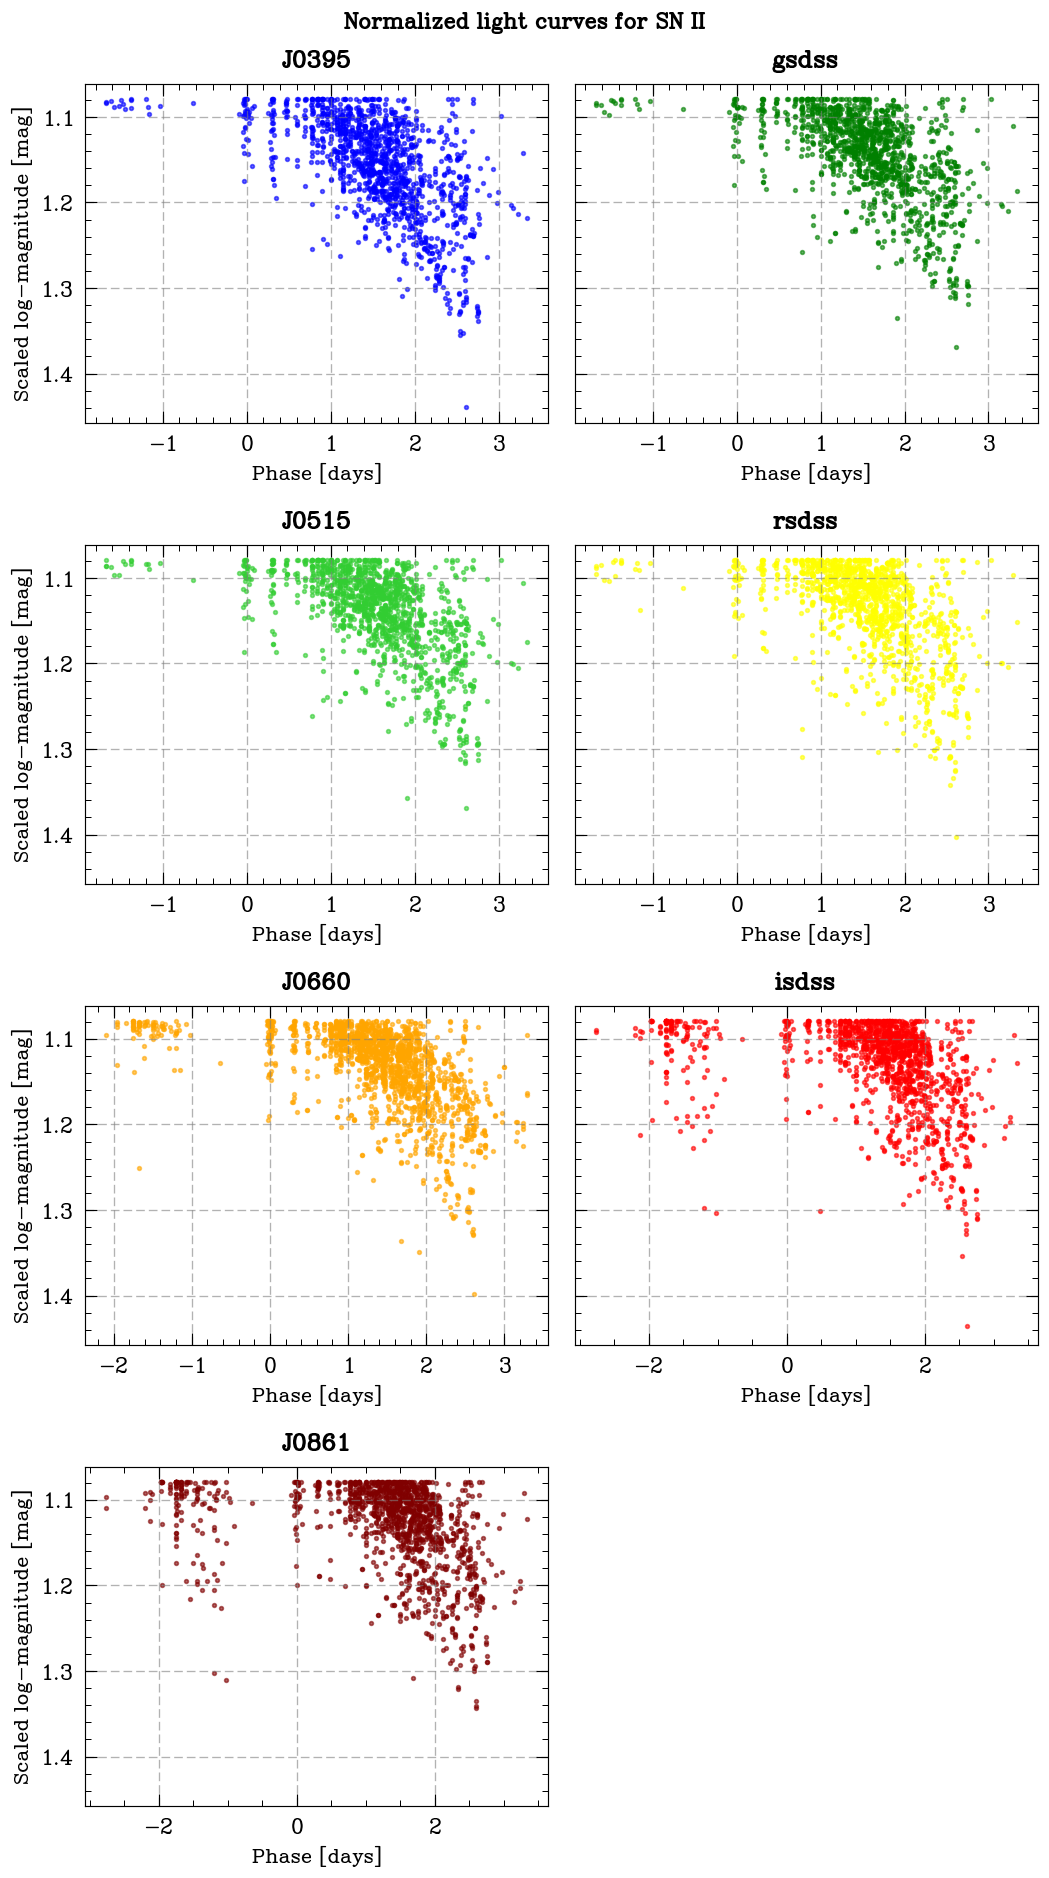

In [22]:
# Function to plot all SN light curves in separate panels for each filter, organized in 2 columns
def plot_all_sns_by_filter(tables, bands, color_map, time_column='Time', mag_suffix='_mag', error_prefix='e_', s=None):
    
    if s is None:
        s = 5
    
    n_bands = len(bands)
    n_cols = 2
    n_rows = (n_bands + n_cols - 1) // n_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4 * n_rows), sharey=True)
    axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over

    for i, band in enumerate(bands):
        ax = axes[i]
        xlim_min, xlim_max = np.inf, -np.inf
        
        for table in tables:# for each SN
            time = table[time_column]
            
            if f"{band}{mag_suffix}" in table.colnames:
                mag = table[f"{band}{mag_suffix}"]
                color = color_map.get(band, 'black')

                # Find peak of the light curve
                max_indice = np.argmin(mag)
                time_max = time[max_indice]
                mag_max = mag[max_indice]

                # set t=0 for the peak
                JD = time - time_max
                
                mag_error_col = f"{error_prefix}{band}{mag_suffix}"
                mag_error = table[mag_error_col] if mag_error_col in table.colnames else None
                mag_norm = mag - np.nanmin(mag) + 12
                
                if mag_error is not None:
                    ax.errorbar(np.log10(JD), np.log10(mag_norm), yerr=mag_error, label=band, color=color, fmt='o', capsize=3, markersize=s, alpha=0.6)
                else:
                    ax.scatter(np.log10(JD), np.log10(mag_norm), label=band, color=color, s=s, alpha=0.6)
        
        ax.set_xlabel('Phase [days]', fontsize=14)
        ax.set_title(f"{band}", fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True)
        
        if i % n_cols == 0:
            ax.set_ylabel('Scaled log-magnitude [mag]', fontsize=14)
    
    # Remove empty subplot if number of bands is odd
    if n_bands % n_cols != 0:
        fig.delaxes(axes[-1])

    fig.suptitle('Normalized light curves for SN II', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Color map and bands definition
color_map = {'J0395': 'blue', 'gsdss': 'green', 'J0515': 'limegreen', 'rsdss': 'yellow',
        'J0660': 'orange', 'isdss': 'red', 'J0861': 'maroon'}
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Plot light curves panel by filter for all SNe
plot_all_sns_by_filter(SNII_phot, bands, color_map)

## Appendix C: Light curves with s-factor

### SN Ia light curves 

In [23]:
# Function I: Plot the light curves with splines as panels
def fit_light_curves_panel(tables, bands, color_map, object_names, time_column='Time', mag_suffix='_mag', error_prefix='e_', s=None):
    n = len(object_names)
    n_cols = 2
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows), sharex=False, sharey=True)
    axes = axes.flatten()

    for i, object_name in enumerate(object_names):
        ax = axes[i]
        table = find_object(object_name, tables)

        if table is not None:
            # Extract type and redshift if available
            object_type = table['Type'][0] if 'Type' in table.colnames else 'Unknown'
            redshift = table['Redshift'][0] if 'Redshift' in table.colnames else 0.0

            xlim_min, xlim_max = fit_light_curves(table, bands, object_name, color_map, time_column, mag_suffix, error_prefix, s, ax)
            ax.set_xlim(xlim_min-10, xlim_max+10)
            ax.set_title(rf"{object_name} ({object_type}, z$=${redshift:.5f})", fontweight='bold')
            ax.invert_yaxis() 
        else:
            ax.text(0.5, 0.5, f'No data for {object_name}', ha='center', va='center', fontsize=6)
            ax.set_title(object_name, fontweight='bold')
            ax.invert_yaxis() 

    # Remove empty subplots
    for j in range(len(object_names), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.gca().invert_yaxis()
    #plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/SNs_light_curve_panel_fits.pdf')
    plt.show()

# Function II: Fit the light curves with splines method
def fit_light_curves(table, bands, object_name, color_map, time_column='Time', mag_suffix='_mag', error_prefix='e_', s=None, ax=None):
    xlim_min = float('inf')
    xlim_max = float('-inf')

    for band in bands:
        # Extract data for the current band
        time = table[time_column] - np.min(table[time_column])
        mag = table[f'{band}{mag_suffix}']
        
        # Avoid NaN values
        valid_indices = ~np.isnan(time) & ~np.isnan(mag)
        time_clean = time[valid_indices]
        mag_clean = mag[valid_indices]

        # Restrict data to x <= 125
        valid_indices = time_clean <= 100
        time_clean = time_clean[valid_indices]
        mag_clean = mag_clean[valid_indices]

        # Find peak of the light curve
        max_indice = np.argmin(mag_clean)
        time_max = time_clean[max_indice]
        mag_max = mag_clean[max_indice]

        time_clean = time_clean - time_max
        mag_norm = mag_clean - np.nanmin(mag_clean) + 12
        
        # Spline fit
        spline = UnivariateSpline(time_clean, mag_norm, k=5)
        time_fit = np.linspace(np.min(time_clean), np.max(time_clean), 1000)
        mag_fit = spline(time_fit)
        
        # Plot data and spline fit
        ax.plot(time_clean, mag_norm, '.', color=color_map[band])
        ax.invert_yaxis() 
        ax.plot(time_fit, mag_fit, '-', color=color_map[band], label=f'{band}')
        ax.invert_yaxis() 

        # Update xlim
        xlim_min = min(xlim_min, time_clean.min())
        xlim_max = 100

    # Customize the plot
    ax.set_xlabel('Phase [days]')
    ax.set_ylabel('Magnitude [mag]')
    ax.legend(frameon=True, fontsize=8)
    ax.axvline(x=0, color='gray', linestyle='--')
    ax.invert_yaxis() 
    
    return xlim_min, xlim_max

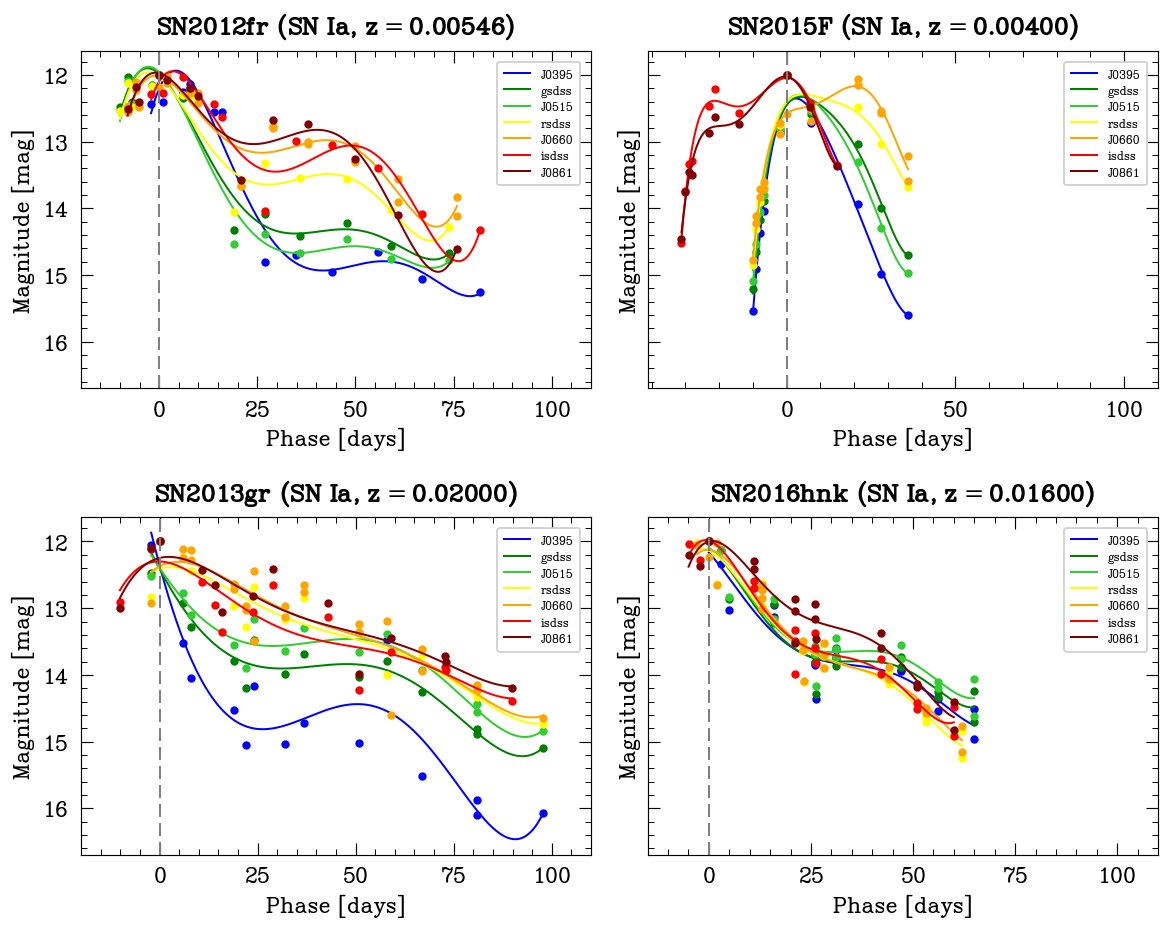

In [24]:
# Panel plot of different light curves
color_map = {'J0395': 'blue', 'gsdss': 'green', 'J0515': 'limegreen', 'rsdss': 'yellow',
        'J0660': 'orange', 'isdss': 'red', 'J0861': 'maroon'}
bands = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']
#bands = ['gsdss']

# SN objects to plot
object_names = ['SN2012fr', 'SN2015F', 'SN2013gr', 'SN2016hnk']

# Plot
fit_light_curves_panel(PESSTO_phot, bands, color_map, object_names)

### s-factor estimation

In [25]:
# Sciencie curve
refcurve = find_object('SN2015F')
# Reference curve
scicurve = find_object('SN2012fr')

In [26]:
# Function to clean data points
def clean_and_norm_data(time, mag):

    # Transform data
    valid_indices = ~np.isnan(time) & ~np.isnan(mag)
    time_clean = time[valid_indices]
    mag_clean = mag[valid_indices]

    # Find the peak of the light curve
    max_indice = np.argmin(mag_clean)
    time_max = time_clean[max_indice]
    mag_max = mag_clean[max_indice]

    time_clean = time_clean - time_max
    
    # Restrict data to t <= limit_days days
    limit_days = 80
    valid_indices = time_clean <= limit_days
    time_clean = time_clean[valid_indices]
    mag_clean = mag_clean[valid_indices]
    
    mag_norm = mag_clean - np.nanmin(mag_clean) + 12

    return time_clean, mag_norm

# Function to make a splines fit
def splines_fit(time, mag):

    spline = UnivariateSpline(time, mag, k=5)
    time_fit = np.linspace(np.min(time), np.max(time), 1000)
    mag_fit = spline(time_fit)

    return time_fit, mag_fit

# Function to make a linear interpolation fit
def linear_interpolation_fit(time, mag):
    # Crear el objeto de interpolación lineal
    interp_func = interp1d(time, mag, kind='linear', fill_value='extrapolate')

    # Generar los valores ajustados
    time_fit = np.linspace(np.min(time), np.max(time), 1000)
    mag_fit = interp_func(time_fit)

    return time_fit, mag_fit

# Function to make a polinomial plot
def polynomial_fit(time, mag, degree=8):
    # Ajustar el polinomio a los datos
    coefficients = np.polyfit(time, mag, deg=degree)

    # Crear el polinomio a partir de los coeficientes
    polynomial = np.poly1d(coefficients)

    # Generar los valores ajustados
    time_fit = np.linspace(np.min(time), np.max(time), 1000)
    mag_fit = polynomial(time_fit)

    return time_fit, mag_fit

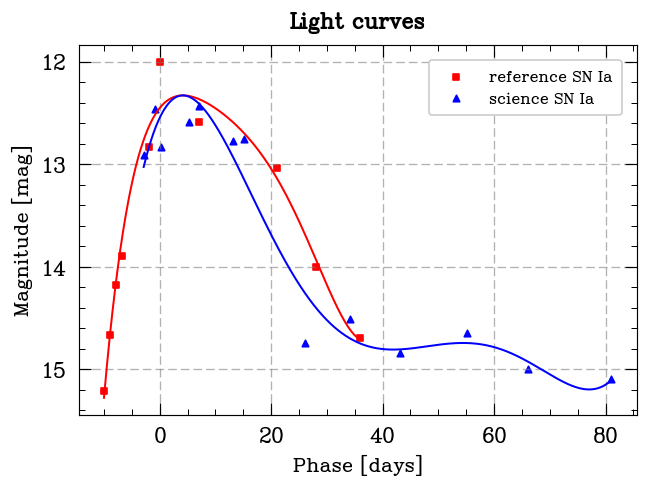

In [27]:
# Data
sci_mag = scicurve['gsdss_mag']; ref_mag = refcurve['gsdss_mag']
sci_JD = scicurve['Time']; ref_JD = refcurve['Time']

# Data transform
sci_JD, sci_mag = clean_and_norm_data(sci_JD, sci_mag)
ref_JD, ref_mag = clean_and_norm_data(ref_JD, ref_mag)

ref_JD_fit, ref_mag_fit = splines_fit(ref_JD, ref_mag)
sci_JD_fit, sci_mag_fit = splines_fit(sci_JD, sci_mag)

# Adjust peaks
sci_max_index = np.argmin(sci_mag_fit); ref_max_index = np.argmin(ref_mag_fit)
sci_JD_at_max_mag = sci_JD_fit[sci_max_index]; ref_JD_at_max_mag = ref_JD_fit[ref_max_index]

sci_JD = sci_JD + np.abs(sci_JD_at_max_mag - ref_JD_at_max_mag)
sci_JD_fit = sci_JD_fit + np.abs(sci_JD_at_max_mag - ref_JD_at_max_mag)

sci_max_index = np.argmin(sci_mag_fit); ref_max_index = np.argmin(ref_mag_fit)
sci_mag_at_max_mag = sci_mag_fit[sci_max_index]; ref_mag_at_max_mag = ref_mag_fit[ref_max_index]

sci_mag = sci_mag + np.abs(ref_mag_at_max_mag - sci_mag_at_max_mag)
sci_mag_fit = sci_mag_fit + np.abs(ref_mag_at_max_mag - sci_mag_at_max_mag)

# Light curves
plt.figure(figsize=(6, 4))

# Data points
plt.scatter(ref_JD, ref_mag, color = 'red', label = 'reference SN Ia', s = 15, marker = 's')
plt.scatter(sci_JD, sci_mag, color = 'blue', label = 'science SN Ia', s = 15, marker = '^')

# Data fits
plt.plot(ref_JD_fit, ref_mag_fit, '-', color = 'red')
plt.plot(sci_JD_fit, sci_mag_fit, '-', color = 'blue')

# Plot configuration
plt.xlabel('Phase [days]', fontsize=14)
plt.ylabel('Magnitude [mag]', fontsize=14)
plt.title('Light curves', fontsize=16, fontweight='bold')

plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize = 11, frameon = True)

#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/stretch_factor_1.pdf')
plt.show()

In [28]:
def loss_function(s, sci_JD_fit, sci_mag_fit, ref_JD_fit, ref_mag_fit):
    # Escalar el eje temporal de la curva de ciencia
    sci_JD_scaled = sci_JD_fit * (1/s)
    
    # Interpolación spline de la curva de ciencia en los puntos de la curva de referencia
    interp_sci_mag = interp1d(sci_JD_scaled, sci_mag_fit, bounds_error=False, fill_value="extrapolate")
    sci_mag_interpolated = interp_sci_mag(ref_JD_fit)
    
    # Calcular la diferencia cuadrada entre la curva de referencia y la ciencia escalada
    difference = ref_mag_fit - sci_mag_interpolated
    loss = np.sum(difference**2)
    
    return loss

# Estimación inicial de s
s_initial = 1.0

# Optimización
result = minimize(loss_function, s_initial, args=(sci_JD_fit, sci_mag_fit, ref_JD_fit, ref_mag_fit), method='Nelder-Mead')

# Mejor valor de s encontrado
best_s = result.x[0]
print(f"Mejor factor de escala (s): {best_s:.4f}")

Mejor factor de escala (s): 0.8119


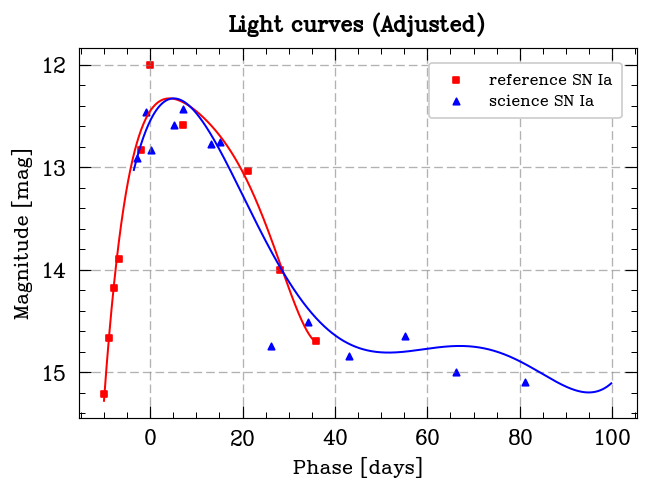

In [29]:
# Reescalar la curva de ciencia con el mejor valor de s
sci_JD_scaled = sci_JD_fit / best_s

# Graficar las curvas originales y ajustadas
plt.figure(figsize=(6, 4))

# Datos originales
plt.scatter(ref_JD, ref_mag, color='red', label='reference SN Ia', s=15, marker='s')
plt.scatter(sci_JD, sci_mag, color='blue', label='science SN Ia', s=15, marker='^')

# Ajuste de spline
plt.plot(ref_JD_fit, ref_mag_fit, '-', color='red')
plt.plot(sci_JD_scaled, sci_mag_fit, '-', color='blue')

# Configuración del gráfico
plt.xlabel('Phase [days]', fontsize=14)
plt.ylabel('Magnitude [mag]', fontsize=14)
plt.title('Light curves (Adjusted)', fontsize=16, fontweight='bold')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize=11, frameon=True)

#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/stretch_factor_2.pdf')
plt.show()

### s-factor for all SN Ia

In [30]:
# SNIa
SNIa_phot = [table for table in PESSTO_phot if 'SN Ia' in table['Type']]

unique_names = []
for table in SNIa_phot:
    if 'ID' in table.colnames:  
        obj_name = table['ID'][0]  
        if obj_name != 'SN2015F':
            unique_names.append(obj_name)

unique_names_SNIa = list(set(unique_names))

# Reference curve
refcurve = find_object('SN2015F')
ref_mag = refcurve['gsdss_mag']
ref_JD = refcurve['Time']
ref_JD, ref_mag = clean_and_norm_data(ref_JD, ref_mag)
ref_JD_fit, ref_mag_fit = splines_fit(ref_JD, ref_mag)

100%|██████████████████████████████████████| 1182/1182 [00:08<00:00, 146.51it/s]


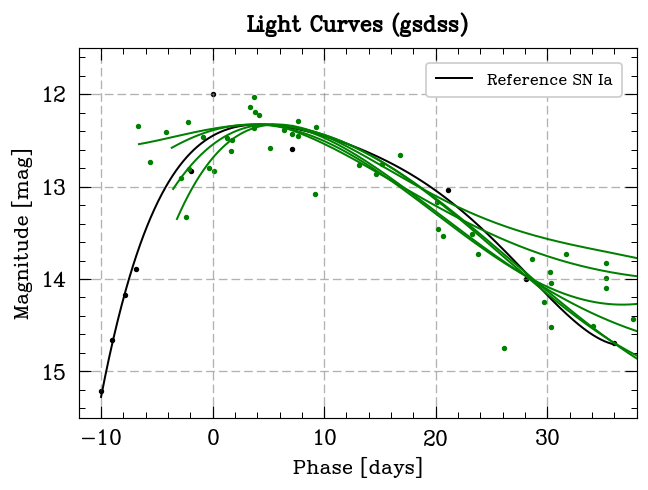

In [31]:
# Data to collect
all_sci_JD = []
all_sci_mag = []
all_sci_JD_scaled = []
all_sci_mag_fit = []

# Loop
for SNIa_name in tqdm(unique_names_SNIa):
    try:
        scicurve = find_object(SNIa_name)
        
        # Data
        sci_mag = scicurve['gsdss_mag']
        sci_JD = scicurve['Time']
        
        sci_JD, sci_mag = clean_and_norm_data(sci_JD, sci_mag)
        
        # Fit y normalización
        sci_JD_fit, sci_mag_fit = splines_fit(sci_JD, sci_mag)
        ref_JD_fit, ref_mag_fit = splines_fit(ref_JD, ref_mag)
        
        sci_max_index = np.argmin(sci_mag_fit)
        ref_max_index = np.argmin(ref_mag_fit)
        
        sci_JD_at_max_mag = sci_JD_fit[sci_max_index]
        ref_JD_at_max_mag = ref_JD_fit[ref_max_index]
        
        if ref_JD_at_max_mag > sci_JD_at_max_mag:
            sci_JD += np.abs(sci_JD_at_max_mag - ref_JD_at_max_mag)
            sci_JD_fit += np.abs(sci_JD_at_max_mag - ref_JD_at_max_mag)
        else:
            sci_JD += np.abs(ref_JD_at_max_mag - sci_JD_at_max_mag)
            sci_JD_fit += np.abs(ref_JD_at_max_mag - sci_JD_at_max_mag)
        
        sci_max_index = np.argmin(sci_mag_fit)
        ref_max_index = np.argmin(ref_mag_fit)
        
        sci_mag_at_max_mag = sci_mag_fit[sci_max_index]
        ref_mag_at_max_mag = ref_mag_fit[ref_max_index]
        
        if ref_JD_at_max_mag > sci_JD_at_max_mag:
            sci_mag += np.abs(ref_mag_at_max_mag - sci_mag_at_max_mag)
            sci_mag_fit += np.abs(ref_mag_at_max_mag - sci_mag_at_max_mag)
        else:
            sci_mag += np.abs(sci_mag_at_max_mag - ref_mag_at_max_mag)
            sci_mag_fit += np.abs(sci_mag_at_max_mag - ref_mag_at_max_mag)
            
        # s-factor
        s_initial = 1.0
        result = minimize(loss_function, s_initial, args=(sci_JD_fit, sci_mag_fit, ref_JD_fit, ref_mag_fit), method='Nelder-Mead')
        best_s = result.x[0]
        
        # Re-escalar
        sci_JD_scaled = sci_JD_fit / best_s
        
        # Almacenar datos de ciencia
        if 0.7 < best_s < 1.6:
        
            all_sci_JD.append(sci_JD)
            all_sci_mag.append(sci_mag)
            all_sci_JD_scaled.append(sci_JD_scaled)
            all_sci_mag_fit.append(sci_mag_fit)
            
    except:
        continue

# Plot
plt.figure(figsize=(6, 4))

# Plot reference curve
plt.scatter(ref_JD, ref_mag, color='black', marker='o', s=5)
plt.plot(ref_JD_fit, ref_mag_fit, '-', color='black', label='Reference SN Ia')

# Plot sciencies curves
for i in range(len(all_sci_JD)):
    plt.scatter(all_sci_JD[i], all_sci_mag[i], s=5, marker='o', color='green')
    plt.plot(all_sci_JD_scaled[i], all_sci_mag_fit[i], '-', color='green')

plt.xlabel('Phase [days]', fontsize=14)
plt.ylabel('Magnitude [mag]', fontsize=14)
plt.title('Light Curves (gsdss)', fontsize=16, fontweight='bold')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize=11, frameon=True, loc='best')
plt.ylim(15.5,11.5)
plt.xlim(-12,38)

#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/universal_light_curve_SNIa_gsdss.pdf')
plt.show()

100%|██████████████████████████████████████| 1182/1182 [00:09<00:00, 121.57it/s]


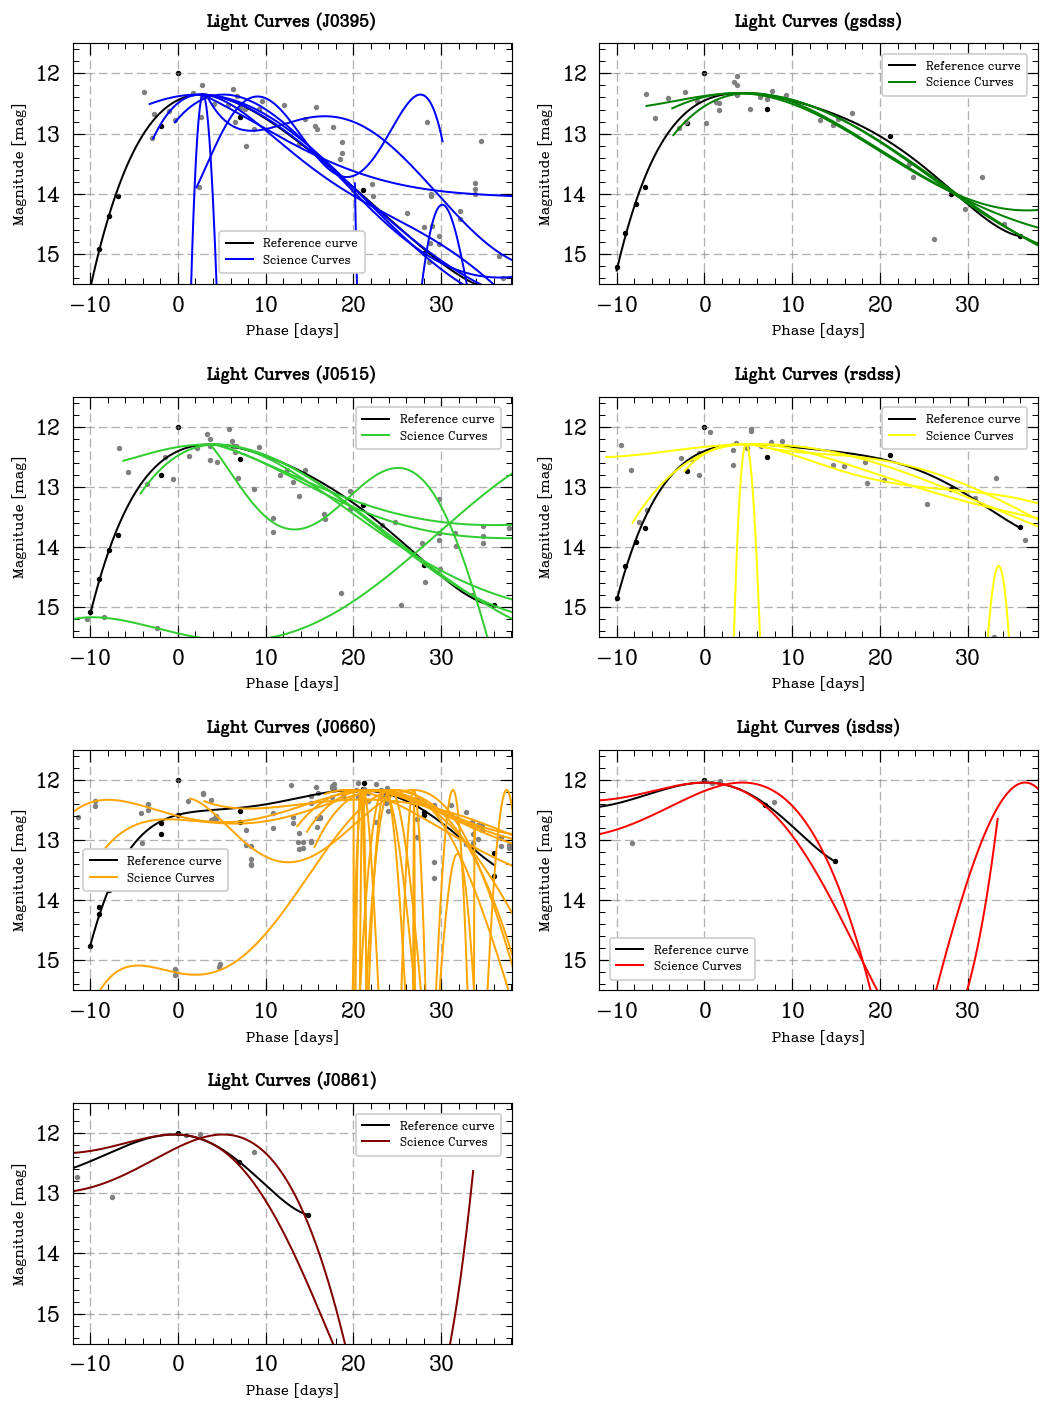

In [32]:
# Filters to consider (without '_mag' for titles and colors)
filters = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Color map for the bands
color_map = {'J0395': 'blue', 'gsdss': 'green', 'J0515': 'limegreen', 'rsdss': 'yellow',
             'J0660': 'orange', 'isdss': 'red', 'J0861': 'maroon'}

# SNIa
SNIa_phot = [table for table in PESSTO_phot if 'SN Ia' in table['Type']]

reference_name = 'SN2015F' #'SN2015F'

unique_names = []
for table in SNIa_phot:
    if 'ID' in table.colnames:  
        obj_name = table['ID'][0]  
        if obj_name != reference_name:
            unique_names.append(obj_name)

unique_names_SNIa = list(set(unique_names))

# Reference curve (SN2015F)
refcurve = find_object(reference_name)
ref_JD = refcurve['Time']

# Plot configuration
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9, 12))  # Adjusted plot size
axes = axes.flatten()

for i, filter_name in enumerate(filters):
    # Get reference data for the current filter
    ref_mag = refcurve[f'{filter_name}_mag']
    ref_JD_clean, ref_mag_clean = clean_and_norm_data(ref_JD, ref_mag)
    ref_JD_fit, ref_mag_fit = splines_fit(ref_JD_clean, ref_mag_clean)
    
    # Data to collect
    all_sci_JD = []
    all_sci_mag = []
    all_sci_JD_scaled = []
    all_sci_mag_fit = []

    # Loop for each supernova
    for SNIa_name in tqdm(unique_names_SNIa):
        try:
            scicurve = find_object(SNIa_name)
            
            # Science curve data
            sci_mag = scicurve[f'{filter_name}_mag']
            sci_JD = scicurve['Time']
            
            sci_JD_clean, sci_mag_clean = clean_and_norm_data(sci_JD, sci_mag)
            
            # Fitting and normalization
            sci_JD_fit, sci_mag_fit = splines_fit(sci_JD_clean, sci_mag_clean)
            
            sci_max_index = np.argmin(sci_mag_fit)
            ref_max_index = np.argmin(ref_mag_fit)
            
            sci_JD_at_max_mag = sci_JD_fit[sci_max_index]
            ref_JD_at_max_mag = ref_JD_fit[ref_max_index]
            
            if ref_JD_at_max_mag > sci_JD_at_max_mag:
                sci_JD_clean += np.abs(sci_JD_at_max_mag - ref_JD_at_max_mag)
                sci_JD_fit += np.abs(sci_JD_at_max_mag - ref_JD_at_max_mag)
            else:
                sci_JD_clean += np.abs(ref_JD_at_max_mag - sci_JD_at_max_mag)
                sci_JD_fit += np.abs(ref_JD_at_max_mag - sci_JD_at_max_mag)
            
            sci_mag_at_max_mag = sci_mag_fit[sci_max_index]
            ref_mag_at_max_mag = ref_mag_fit[ref_max_index]
            
            if ref_JD_at_max_mag > sci_JD_at_max_mag:
                sci_mag_clean += np.abs(ref_mag_at_max_mag - sci_mag_at_max_mag)
                sci_mag_fit += np.abs(ref_mag_at_max_mag - sci_mag_at_max_mag)
            else:
                sci_mag_clean += np.abs(sci_mag_at_max_mag - ref_mag_at_max_mag)
                sci_mag_fit += np.abs(sci_mag_at_max_mag - ref_mag_at_max_mag)
                
            # s-factor
            s_initial = 1.0
            result = minimize(loss_function, s_initial, args=(sci_JD_fit, sci_mag_fit, ref_JD_fit, ref_mag_fit), method='Nelder-Mead')
            best_s = result.x[0]
            
            # Rescale
            sci_JD_scaled = sci_JD_fit / best_s
            
            # Store science data
            if 0.8 < best_s < 1.2:
                all_sci_JD.append(sci_JD_clean)
                all_sci_mag.append(sci_mag_clean)
                all_sci_JD_scaled.append(sci_JD_scaled)
                all_sci_mag_fit.append(sci_mag_fit)
                
        except:
            continue

    # Plot for the current filter
    ax = axes[i]
    
    # Plot reference
    ax.scatter(ref_JD_clean, ref_mag_clean, color='black', marker='o', s=5)
    ax.plot(ref_JD_fit, ref_mag_fit, '-', color='black', label='Reference curve')
    
    # Plot science curves with a single label
    lines = []
    for j in range(len(all_sci_JD)):
        sci_line, = ax.plot(all_sci_JD_scaled[j], all_sci_mag_fit[j], '-', color=color_map[filter_name])
        if j == 0:  # Add the label only for the first line to avoid duplicates
            lines.append(Line2D([0], [0], color=color_map[filter_name], linestyle='-', label='Science curves'))
        ax.scatter(all_sci_JD[j], all_sci_mag[j], s=5, marker='o', color='gray')
    
    # Combine all labels into one legend
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(lines)  # Add custom lines to the legend
    labels.extend(['Science Curves'])  # Add custom label to the legend
    ax.legend(handles, labels, fontsize=8, frameon=True, loc='best')
    
    ax.set_xlabel('Phase [days]', fontsize=10)
    ax.set_ylabel('Magnitude [mag]', fontsize=10)
    ax.set_title(f'Light Curves ({filter_name})', fontsize=12, fontweight='bold')
    ax.grid(True)
    ax.invert_yaxis()
    ax.set_ylim(15.5, 11.5)
    ax.set_xlim(-12, 38)

# Remove the last unused subplot
fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/universal_light_curve_SNIa.pdf')
plt.show()

### s-factor for all SN II

In [33]:
# SNII
SNII_phot = [table for table in PESSTO_phot if 'SN II' or 'SN IIn' or 'SN IIb' or 'SN IIP' in table['Type']]

unique_names = []
for table in SNII_phot:
    if 'ID' in table.colnames:  
        obj_name = table['ID'][0]  
        if obj_name != 'SN2013ej':
            unique_names.append(obj_name)

unique_names_SNII = list(set(unique_names))

# Reference curve
refcurve = find_object('SN2013ej')
ref_mag = refcurve['gsdss_mag']
ref_JD = refcurve['Time']
ref_JD, ref_mag = clean_and_norm_data(ref_JD, ref_mag)
ref_JD_fit, ref_mag_fit = splines_fit(ref_JD, ref_mag)

100%|██████████████████████████████████████| 2143/2143 [00:17<00:00, 122.69it/s]


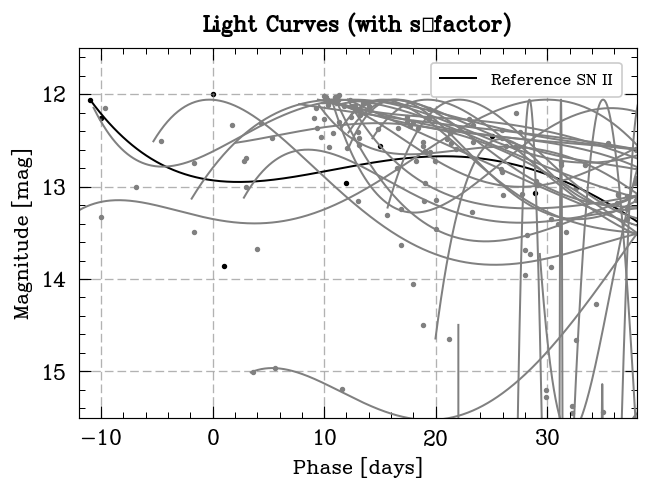

In [34]:
# Data to collect
all_sci_JD = []
all_sci_mag = []
all_sci_JD_scaled = []
all_sci_mag_fit = []

# Loop
for SNII_name in tqdm(unique_names_SNII):
    try:
        scicurve = find_object(SNII_name)
        
        # Data
        sci_mag = scicurve['gsdss_mag']
        sci_JD = scicurve['Time']
        
        sci_JD, sci_mag = clean_and_norm_data(sci_JD, sci_mag)
        
        # Fit y normalización
        sci_JD_fit, sci_mag_fit = splines_fit(sci_JD, sci_mag)
        ref_JD_fit, ref_mag_fit = splines_fit(ref_JD, ref_mag)
        
        sci_max_index = np.argmin(sci_mag_fit)
        ref_max_index = np.argmin(ref_mag_fit)
        
        sci_JD_at_max_mag = sci_JD_fit[sci_max_index]
        ref_JD_at_max_mag = ref_JD_fit[ref_max_index]
        
        if ref_JD_at_max_mag > sci_JD_at_max_mag:
            sci_JD += np.abs(sci_JD_at_max_mag - ref_JD_at_max_mag)
            sci_JD_fit += np.abs(sci_JD_at_max_mag - ref_JD_at_max_mag)
        else:
            sci_JD += np.abs(ref_JD_at_max_mag - sci_JD_at_max_mag)
            sci_JD_fit += np.abs(ref_JD_at_max_mag - sci_JD_at_max_mag)
        
        sci_max_index = np.argmin(sci_mag_fit)
        ref_max_index = np.argmin(ref_mag_fit)
        
        sci_mag_at_max_mag = sci_mag_fit[sci_max_index]
        ref_mag_at_max_mag = ref_mag_fit[ref_max_index]
        
        if ref_JD_at_max_mag > sci_JD_at_max_mag:
            sci_mag += np.abs(ref_mag_at_max_mag - sci_mag_at_max_mag)
            sci_mag_fit += np.abs(ref_mag_at_max_mag - sci_mag_at_max_mag)
        else:
            sci_mag += np.abs(sci_mag_at_max_mag - ref_mag_at_max_mag)
            sci_mag_fit += np.abs(sci_mag_at_max_mag - ref_mag_at_max_mag)
            
        # s-factor
        s_initial = 1.0
        result = minimize(loss_function, s_initial, args=(sci_JD_fit, sci_mag_fit, ref_JD_fit, ref_mag_fit), method='Nelder-Mead')
        best_s = result.x[0]
        
        # Re-escalar
        sci_JD_scaled = sci_JD_fit / best_s
        
        # Almacenar datos de ciencia
        if 0.8 < best_s < 1.2:
        
            all_sci_JD.append(sci_JD)
            all_sci_mag.append(sci_mag)
            all_sci_JD_scaled.append(sci_JD_scaled)
            all_sci_mag_fit.append(sci_mag_fit)
            
    except:
        continue

# Plot
plt.figure(figsize=(6, 4))

# Plot reference curve
plt.scatter(ref_JD, ref_mag, color='black', marker='o', s=5)
plt.plot(ref_JD_fit, ref_mag_fit, '-', color='black', label='Reference SN II')

# Plot sciencies curves
for i in range(len(all_sci_JD)):
    plt.scatter(all_sci_JD[i], all_sci_mag[i], s=5, marker='o', color='gray')
    plt.plot(all_sci_JD_scaled[i], all_sci_mag_fit[i], '-', color='gray')

plt.xlabel('Phase [days]', fontsize=14)
plt.ylabel('Magnitude [mag]', fontsize=14)
plt.title('Light Curves (with s-factor)', fontsize=16, fontweight='bold')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize=11, frameon=True, loc='best')
plt.ylim(15.5,11.5)
plt.xlim(-12,38)
plt.show()

100%|██████████████████████████████████████| 1183/1183 [00:11<00:00, 102.23it/s]


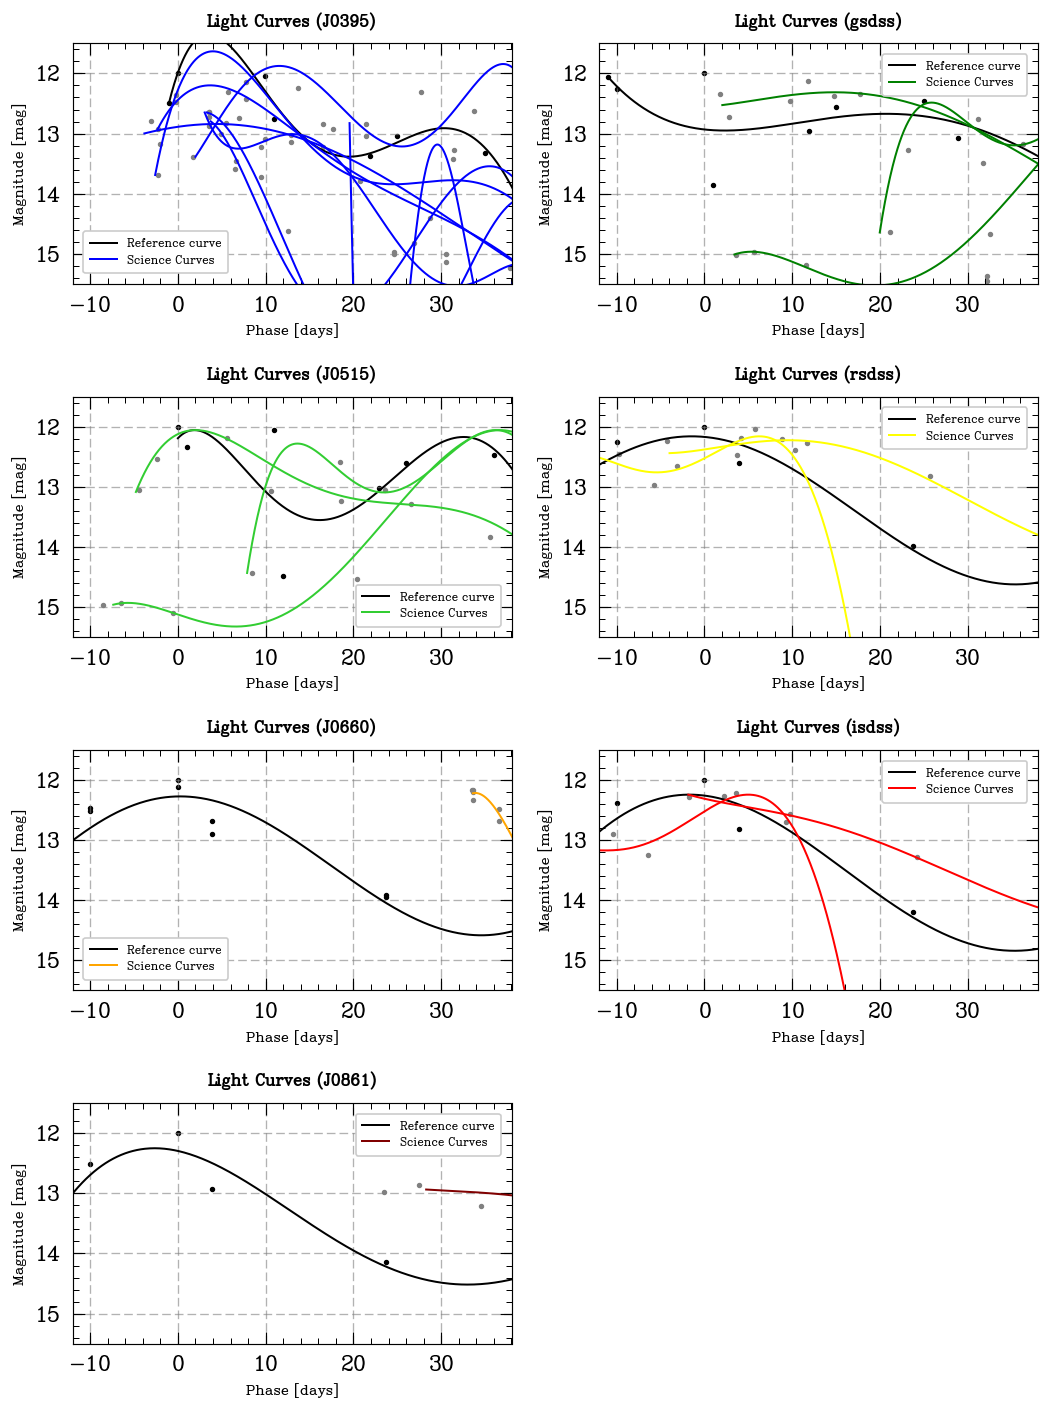

In [35]:
# Filters to consider (without '_mag' for titles and colors)
filters = ['J0395', 'gsdss', 'J0515', 'rsdss', 'J0660', 'isdss', 'J0861']

# Color map for the bands
color_map = {'J0395': 'blue', 'gsdss': 'green', 'J0515': 'limegreen', 'rsdss': 'yellow',
             'J0660': 'orange', 'isdss': 'red', 'J0861': 'maroon'}

# SNIa
SNII_phot = [table for table in PESSTO_phot if 'SN II' or 'SN IIn' or 'SN IIb' or 'SN IIP' in table['Type']]

reference_name = 'SN2013ej' #'SN2013ej'

unique_names = []
for table in SNIa_phot:
    if 'ID' in table.colnames:  
        obj_name = table['ID'][0]  
        if obj_name != reference_name:
            unique_names.append(obj_name)

unique_names_SNIa = list(set(unique_names))

# Reference curve (SN2015F)
refcurve = find_object(reference_name)
ref_JD = refcurve['Time']

# Plot configuration
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9, 12))  # Adjusted plot size
axes = axes.flatten()

for i, filter_name in enumerate(filters):
    # Get reference data for the current filter
    ref_mag = refcurve[f'{filter_name}_mag']
    ref_JD_clean, ref_mag_clean = clean_and_norm_data(ref_JD, ref_mag)
    ref_JD_fit, ref_mag_fit = splines_fit(ref_JD_clean, ref_mag_clean)
    
    # Data to collect
    all_sci_JD = []
    all_sci_mag = []
    all_sci_JD_scaled = []
    all_sci_mag_fit = []

    # Loop for each supernova
    for SNIa_name in tqdm(unique_names_SNIa):
        try:
            scicurve = find_object(SNIa_name)
            
            # Science curve data
            sci_mag = scicurve[f'{filter_name}_mag']
            sci_JD = scicurve['Time']
            
            sci_JD_clean, sci_mag_clean = clean_and_norm_data(sci_JD, sci_mag)
            
            # Fitting and normalization
            sci_JD_fit, sci_mag_fit = splines_fit(sci_JD_clean, sci_mag_clean)
            
            sci_max_index = np.argmin(sci_mag_fit)
            ref_max_index = np.argmin(ref_mag_fit)
            
            sci_JD_at_max_mag = sci_JD_fit[sci_max_index]
            ref_JD_at_max_mag = ref_JD_fit[ref_max_index]
            
            if ref_JD_at_max_mag > sci_JD_at_max_mag:
                sci_JD_clean += np.abs(sci_JD_at_max_mag - ref_JD_at_max_mag)
                sci_JD_fit += np.abs(sci_JD_at_max_mag - ref_JD_at_max_mag)
            else:
                sci_JD_clean += np.abs(ref_JD_at_max_mag - sci_JD_at_max_mag)
                sci_JD_fit += np.abs(ref_JD_at_max_mag - sci_JD_at_max_mag)
            
            sci_mag_at_max_mag = sci_mag_fit[sci_max_index]
            ref_mag_at_max_mag = ref_mag_fit[ref_max_index]
            
            if ref_JD_at_max_mag > sci_JD_at_max_mag:
                sci_mag_clean += np.abs(ref_mag_at_max_mag - sci_mag_at_max_mag)
                sci_mag_fit += np.abs(ref_mag_at_max_mag - sci_mag_at_max_mag)
            else:
                sci_mag_clean += np.abs(sci_mag_at_max_mag - ref_mag_at_max_mag)
                sci_mag_fit += np.abs(sci_mag_at_max_mag - ref_mag_at_max_mag)
                
            # s-factor
            s_initial = 1.0
            result = minimize(loss_function, s_initial, args=(sci_JD_fit, sci_mag_fit, ref_JD_fit, ref_mag_fit), method='Nelder-Mead')
            best_s = result.x[0]
            
            # Rescale
            sci_JD_scaled = sci_JD_fit / best_s
            
            # Store science data
            if 0.8 < best_s < 1.2:
                all_sci_JD.append(sci_JD_clean)
                all_sci_mag.append(sci_mag_clean)
                all_sci_JD_scaled.append(sci_JD_scaled)
                all_sci_mag_fit.append(sci_mag_fit)
                
        except:
            continue

    # Plot for the current filter
    ax = axes[i]
    
    # Plot reference
    ax.scatter(ref_JD_clean, ref_mag_clean, color='black', marker='o', s=5)
    ax.plot(ref_JD_fit, ref_mag_fit, '-', color='black', label='Reference curve')
    
    # Plot science curves with a single label
    lines = []
    for j in range(len(all_sci_JD)):
        sci_line, = ax.plot(all_sci_JD_scaled[j], all_sci_mag_fit[j], '-', color=color_map[filter_name])
        if j == 0:  # Add the label only for the first line to avoid duplicates
            lines.append(Line2D([0], [0], color=color_map[filter_name], linestyle='-', label='Science curves'))
        ax.scatter(all_sci_JD[j], all_sci_mag[j], s=5, marker='o', color='gray')
    
    # Combine all labels into one legend
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(lines)  # Add custom lines to the legend
    labels.extend(['Science Curves'])  # Add custom label to the legend
    ax.legend(handles, labels, fontsize=8, frameon=True, loc='best')
    
    ax.set_xlabel('Phase [days]', fontsize=10)
    ax.set_ylabel('Magnitude [mag]', fontsize=10)
    ax.set_title(f'Light Curves ({filter_name})', fontsize=12, fontweight='bold')
    ax.grid(True)
    ax.invert_yaxis()
    ax.set_ylim(15.5, 11.5)
    ax.set_xlim(-12, 38)

# Remove the last unused subplot
fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()

In [36]:
# Ejectuoon Time
b = time_notebook.time()
print(np.round((b-a)/60,2),'min of execution')

7.56 min of execution
